# Grid generation

Generate More Valid Grids (The Design Space)
* Refinement: Grid generation is optional but highly effective. You don't have to rely solely on the original 500,000 grids. If you find a structural pattern that scores high (e.g., a specific mix of zones), you can generate millions of permutations of that pattern to massively expand your pool of valid grids.
* Key Action: Use your top-scoring valid grids to inform a generative model or a guided random search that creates new, highly-scoring grid configurations. This helps find unique, diverse grids that may not exist in the original dataset.


In [62]:
# 🏗️ ADVANCED GRID GENERATION SYSTEM
print("🏗️ Building Advanced Grid Generation System")
print("=" * 50)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter, defaultdict
import random
from itertools import combinations, permutations
import warnings
warnings.filterwarnings('ignore')

# Load Oracle predictions and top grids from previous notebooks
print("📂 Loading Oracle predictions and best grids...")

try:
    # Load Oracle predictions
    predictions = np.load('data/submissions/20251028_012622_oracle_predictions_full.npy')
    print(f"✅ Loaded Oracle predictions: {predictions.shape}")
    
    # Load grid data
    grid_files = ['2155-Challenge-Problem-2/datasets/grids_0.npy', 
                 '2155-Challenge-Problem-2/datasets/grids_1.npy', 
                 '2155-Challenge-Problem-2/datasets/grids_2.npy', 
                 '2155-Challenge-Problem-2/datasets/grids_3.npy', 
                 '2155-Challenge-Problem-2/datasets/grids_4.npy']
    
    grid_data_chunks = []
    for file in grid_files:
        grids_chunk = np.load(file)
        grid_data_chunks.append(grids_chunk)
        print(f"   📁 Loaded {file}: {grids_chunk.shape}")
    
    grids = np.vstack(grid_data_chunks)
    print(f"✅ Combined grid data: {grids.shape}")
    
    # Calculate minimum scores
    min_scores = np.min(predictions, axis=1)
    advisor_names = ['Wellness', 'Tax', 'Transportation', 'Business']
    
    print(f"📊 Data Summary:")
    print(f"   Total grids: {len(grids):,}")
    print(f"   Predictions shape: {predictions.shape}")
    print(f"   Min score range: {np.min(min_scores):.4f} - {np.max(min_scores):.4f}")
    
    # Find the best performing grids from existing dataset
    top_threshold = 0.75  # Start with basic validity
    valid_mask = min_scores >= top_threshold
    n_valid = np.sum(valid_mask)
    
    print(f"\n🎯 Current Valid Grids Analysis:")
    print(f"   Grids passing {top_threshold}: {n_valid:,} ({n_valid/len(grids)*100:.3f}%)")
    
    if n_valid > 0:
        best_indices = np.where(valid_mask)[0]
        best_grids = grids[best_indices]
        best_predictions = predictions[best_indices]
        best_min_scores = min_scores[best_indices]
        
        print(f"   Best min score: {np.max(best_min_scores):.4f}")
        print(f"   Best grid index: {best_indices[np.argmax(best_min_scores)]}")
    else:
        print("   ⚠️ No grids pass the 0.75 threshold!")
        # Use top scoring grids instead
        n_top = 1000
        best_indices = np.argsort(min_scores)[-n_top:]
        best_grids = grids[best_indices]
        best_predictions = predictions[best_indices]
        best_min_scores = min_scores[best_indices]
        print(f"   Using top {n_top} scoring grids instead")
        print(f"   Top min score: {np.max(best_min_scores):.4f}")

except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("💡 Creating synthetic example for demonstration...")
    
    # Create synthetic data for demonstration
    np.random.seed(42)
    grids = np.random.randint(0, 5, (10000, 7, 7))
    predictions = np.random.beta(2, 1, (10000, 4)) * 0.4 + 0.5
    min_scores = np.min(predictions, axis=1)
    
    best_indices = np.argsort(min_scores)[-100:]
    best_grids = grids[best_indices]
    best_predictions = predictions[best_indices]
    best_min_scores = min_scores[best_indices]
    
    print(f"📊 Synthetic data created for demonstration")

print(f"\n✅ Setup complete! Ready for grid generation...")
print(f"🎯 Goal: Generate new grids with higher probability of validity")
print(f"📈 Strategy: Learn patterns from best existing grids")

🏗️ Building Advanced Grid Generation System
📂 Loading Oracle predictions and best grids...
✅ Loaded Oracle predictions: (500000, 4)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_0.npy: (100000, 7, 7)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_1.npy: (100000, 7, 7)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_2.npy: (100000, 7, 7)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_3.npy: (100000, 7, 7)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_4.npy: (100000, 7, 7)
✅ Combined grid data: (500000, 7, 7)
📊 Data Summary:
   Total grids: 500,000
   Predictions shape: (500000, 4)
   Min score range: -0.2058 - 0.9877

🎯 Current Valid Grids Analysis:
   Grids passing 0.75: 647 (0.129%)
   Best min score: 0.9877
   Best grid index: 440648

✅ Setup complete! Ready for grid generation...
🎯 Goal: Generate new grids with higher probability of validity
📈 Strategy: Learn patterns from best existing grids


In [63]:
# 🧬 GENETIC ALGORITHM GRID GENERATION SYSTEM
print("🧬 Genetic Algorithm Grid Generation System")
print("=" * 50)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import warnings
warnings.filterwarnings('ignore')

class GeneticGridGenerator:
    """Genetic algorithm for generating diverse, high-scoring grids"""
    
    def __init__(self, seed_grids, seed_predictions, oracle_predictor=None):
        self.seed_grids = seed_grids
        self.seed_predictions = seed_predictions
        self.oracle_predictor = oracle_predictor
        self.advisor_names = ["Wellness", "Tax", "Transportation", "Business"]
        self.best_grids_history = []
        
    def select_high_scoring_parents(self, top_k=200, diversity_threshold=0.3):
        """Select high-scoring diverse grids as initial population"""
        print(f"🎯 Selecting top {top_k} high-scoring diverse grids as parents...")
        
        # Calculate minimum scores
        min_scores = np.min(self.seed_predictions, axis=1)
        
        # Get top scoring indices
        top_indices = np.argsort(min_scores)[-top_k*3:]  # Get more candidates first
        top_grids = self.seed_grids[top_indices]
        top_scores = min_scores[top_indices]
        
        # Select diverse high-scoring grids
        selected_grids = []
        selected_scores = []
        selected_indices = []
        
        # Always include the absolute best
        best_idx = np.argmax(top_scores)
        selected_grids.append(top_grids[best_idx])
        selected_scores.append(top_scores[best_idx])
        selected_indices.append(top_indices[best_idx])
        
        # Select remaining grids based on diversity
        for i in range(len(top_grids)):
            if len(selected_grids) >= top_k:
                break
                
            candidate_grid = top_grids[i]
            candidate_score = top_scores[i]
            
            # Check diversity against already selected grids
            is_diverse = True
            for selected_grid in selected_grids:
                # Calculate hamming distance (different positions / total positions)
                diff_positions = np.sum(candidate_grid != selected_grid)
                diversity = diff_positions / 49.0  # 7x7 = 49 total positions
                
                if diversity < diversity_threshold:
                    is_diverse = False
                    break
            
            if is_diverse:
                selected_grids.append(candidate_grid)
                selected_scores.append(candidate_score)
                selected_indices.append(top_indices[i])
        
        selected_grids = np.array(selected_grids)
        selected_scores = np.array(selected_scores)
        
        print(f"✅ Selected {len(selected_grids)} diverse high-scoring parent grids")
        print(f"   Score range: {np.min(selected_scores):.4f} - {np.max(selected_scores):.4f}")
        print(f"   Mean score: {np.mean(selected_scores):.4f}")
        
        return selected_grids, selected_scores, selected_indices
    
    def mutate_grid(self, grid, mutation_rate=0.3, mutation_intensity='high'):
        """Apply mutations to a grid with high degree of change"""
        mutated_grid = grid.copy()
        
        if mutation_intensity == 'high':
            # High mutation: change 20-40% of positions
            n_mutations = np.random.randint(10, 20)  # 20-40% of 49 positions
        elif mutation_intensity == 'medium':
            # Medium mutation: change 10-25% of positions
            n_mutations = np.random.randint(5, 12)
        else:  # 'low'
            # Low mutation: change 5-15% of positions
            n_mutations = np.random.randint(2, 7)
        
        # Apply mutations
        for _ in range(n_mutations):
            i, j = np.random.randint(0, 7, 2)
            
            # Mutation strategies
            mutation_type = np.random.choice(['random_district', 'swap_nearby', 'cluster_expand'])
            
            if mutation_type == 'random_district':
                # Change to completely random district type
                mutated_grid[i, j] = np.random.randint(0, 5)
                
            elif mutation_type == 'swap_nearby':
                # Swap with a nearby position
                di, dj = np.random.choice([-1, 0, 1], 2)
                ni, nj = min(max(i + di, 0), 6), min(max(j + dj, 0), 6)
                mutated_grid[i, j], mutated_grid[ni, nj] = mutated_grid[ni, nj], mutated_grid[i, j]
                
            elif mutation_type == 'cluster_expand':
                # Expand a nearby cluster
                neighbors = []
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < 7 and 0 <= nj < 7 and (ni != i or nj != j):
                            neighbors.append(mutated_grid[ni, nj])
                
                if neighbors:
                    # Change to most common neighbor type
                    from collections import Counter
                    most_common = Counter(neighbors).most_common(1)[0][0]
                    mutated_grid[i, j] = most_common
        
        return mutated_grid
    
    def crossover_grids(self, parent1, parent2, crossover_type='block'):
        """Create offspring through crossover"""
        child1, child2 = parent1.copy(), parent2.copy()
        
        if crossover_type == 'block':
            # Block crossover: exchange rectangular regions
            x1, y1 = np.random.randint(0, 5, 2)  # Top-left corner
            x2, y2 = np.random.randint(x1+1, 7), np.random.randint(y1+1, 7)  # Bottom-right corner
            
            # Swap the blocks
            child1[x1:x2, y1:y2], child2[x1:x2, y1:y2] = parent2[x1:x2, y1:y2].copy(), parent1[x1:x2, y1:y2].copy()
            
        elif crossover_type == 'diagonal':
            # Diagonal crossover
            for i in range(7):
                for j in range(7):
                    if i + j < 7:  # Upper triangle
                        child1[i, j] = parent2[i, j]
                        child2[i, j] = parent1[i, j]
                        
        elif crossover_type == 'checkerboard':
            # Checkerboard pattern
            for i in range(7):
                for j in range(7):
                    if (i + j) % 2 == 0:
                        child1[i, j] = parent2[i, j]
                        child2[i, j] = parent1[i, j]
        
        return child1, child2
    
    def evaluate_diversity(self, population):
        """Calculate diversity score for a population"""
        if len(population) < 2:
            return 0.0
        
        total_diversity = 0
        comparisons = 0
        
        for i in range(len(population)):
            for j in range(i + 1, len(population)):
                diff_positions = np.sum(population[i] != population[j])
                diversity = diff_positions / 49.0
                total_diversity += diversity
                comparisons += 1
        
        return total_diversity / comparisons if comparisons > 0 else 0.0
    
    def fitness_function(self, predictions, diversity_weight=0.2):
        """Combined fitness function: validity + diversity"""
        min_scores = np.min(predictions, axis=1)
        
        # Base fitness is minimum score
        fitness_scores = min_scores.copy()
        
        # Add diversity bonus (this is approximate, full diversity calculation is expensive)
        # We'll add small random bonus to encourage exploration
        diversity_bonus = np.random.normal(0, 0.02, len(fitness_scores))
        fitness_scores += diversity_weight * diversity_bonus
        
        return fitness_scores
    
    def evolve_population(self, population, predictions, generation):
        """Evolve population for one generation"""
        population_size = len(population)
        
        # Calculate fitness
        fitness_scores = self.fitness_function(predictions)
        
        # Selection: tournament selection
        new_population = []
        
        # Keep top 20% as elites
        elite_size = max(1, population_size // 5)
        elite_indices = np.argsort(fitness_scores)[-elite_size:]
        for idx in elite_indices:
            new_population.append(population[idx])
        
        # Generate rest through crossover and mutation
        while len(new_population) < population_size:
            # Tournament selection for parents
            tournament_size = 3
            parent1_idx = max(np.random.choice(len(population), tournament_size), 
                             key=lambda x: fitness_scores[x])
            parent2_idx = max(np.random.choice(len(population), tournament_size), 
                             key=lambda x: fitness_scores[x])
            
            parent1 = population[parent1_idx]
            parent2 = population[parent2_idx]
            
            # Crossover
            if np.random.random() < 0.7:  # 70% crossover rate
                crossover_type = np.random.choice(['block', 'diagonal', 'checkerboard'])
                child1, child2 = self.crossover_grids(parent1, parent2, crossover_type)
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            
            # Mutation
            mutation_intensity = 'high' if generation < 5 else 'medium'  # High mutation early
            
            if np.random.random() < 0.8:  # 80% mutation rate
                child1 = self.mutate_grid(child1, mutation_intensity=mutation_intensity)
            if np.random.random() < 0.8:
                child2 = self.mutate_grid(child2, mutation_intensity=mutation_intensity)
            
            new_population.extend([child1, child2])
        
        # Trim to exact population size
        return np.array(new_population[:population_size])
    
    def run_genetic_algorithm(self, population_size=300, generations=15, 
                            diversity_selection=True):
        """Run the complete genetic algorithm"""
        print(f"\n🧬 Running Genetic Algorithm:")
        print(f"   Population size: {population_size}")
        print(f"   Generations: {generations}")
        print(f"   Diversity selection: {diversity_selection}")
        
        # Step 1: Select high-scoring diverse parents
        initial_population, initial_scores, _ = self.select_high_scoring_parents(
            top_k=population_size, diversity_threshold=0.2
        )
        
        current_population = initial_population
        generation_stats = []
        
        # Evolution loop
        for generation in range(generations):
            print(f"\n🔄 Generation {generation + 1}/{generations}")
            
            # Evaluate current population using CNN Oracles
            print(f"   🔮 Evaluating population with CNN Oracles...")
            if self.oracle_predictor:
                current_predictions = self.oracle_predictor.predict_all_advisors(current_population)
            else:
                # Fallback: use seed predictions as proxy (shouldn't happen)
                current_predictions = np.random.random((len(current_population), 4)) * 0.3 + 0.5
            
            current_min_scores = np.min(current_predictions, axis=1)
            
            # Calculate diversity
            diversity_score = self.evaluate_diversity(current_population)
            
            # Track statistics
            stats = {
                'generation': generation + 1,
                'best_score': np.max(current_min_scores),
                'mean_score': np.mean(current_min_scores),
                'diversity': diversity_score,
                'valid_count': np.sum(current_min_scores >= 0.75)
            }
            generation_stats.append(stats)
            
            print(f"   📊 Stats: Best={stats['best_score']:.4f}, "
                  f"Mean={stats['mean_score']:.4f}, "
                  f"Diversity={stats['diversity']:.3f}, "
                  f"Valid={stats['valid_count']}")
            
            # Store best grids from this generation
            best_indices = np.argsort(current_min_scores)[-20:]  # Top 20
            self.best_grids_history.extend([
                {
                    'generation': generation + 1,
                    'grid': current_population[idx].copy(),
                    'predictions': current_predictions[idx].copy(),
                    'min_score': current_min_scores[idx]
                }
                for idx in best_indices
            ])
            
            # Early stopping if we find many excellent grids
            if np.sum(current_min_scores >= 0.85) > population_size // 4:
                print(f"   🎉 Early stopping: Found {np.sum(current_min_scores >= 0.85)} excellent grids!")
                break
            
            # Evolve to next generation (except for last generation)
            if generation < generations - 1:
                print(f"   🧬 Evolving to next generation...")
                current_population = self.evolve_population(
                    current_population, current_predictions, generation
                )
        
        # Final evaluation and results
        print(f"\n✅ Genetic Algorithm Complete!")
        
        # Final population evaluation
        final_predictions = self.oracle_predictor.predict_all_advisors(current_population)
        final_min_scores = np.min(final_predictions, axis=1)
        final_diversity = self.evaluate_diversity(current_population)
        
        print(f"📊 Final Population Stats:")
        print(f"   Best score: {np.max(final_min_scores):.4f}")
        print(f"   Mean score: {np.mean(final_min_scores):.4f}")
        print(f"   Diversity: {final_diversity:.3f}")
        print(f"   Valid grids (≥0.75): {np.sum(final_min_scores >= 0.75)}")
        print(f"   High-quality grids (≥0.80): {np.sum(final_min_scores >= 0.80)}")
        print(f"   Excellent grids (≥0.85): {np.sum(final_min_scores >= 0.85)}")
        
        return {
            'final_population': current_population,
            'final_predictions': final_predictions,
            'final_min_scores': final_min_scores,
            'generation_stats': generation_stats,
            'best_grids_history': self.best_grids_history
        }

# Initialize the genetic algorithm system
print(f"🔧 Initializing Genetic Algorithm System...")
print(f"   Available data: {len(grids)} grids, {predictions.shape} predictions")

# We'll initialize this after loading the CNN oracles
genetic_generator = None
print(f"✅ Ready to initialize genetic algorithm after CNN Oracle loading...")

🧬 Genetic Algorithm Grid Generation System
🔧 Initializing Genetic Algorithm System...
   Available data: 500000 grids, (500000, 4) predictions
✅ Ready to initialize genetic algorithm after CNN Oracle loading...


In [64]:
# 🔮 CNN ORACLE LOADING AND INITIALIZATION
print("🔮 Loading CNN Oracle Models for Genetic Algorithm")
print("=" * 55)

import os
import sys
sys.path.append('.')

try:
    # Import CNN oracle classes
    from oracle import CNNTransportationOracle, CNNWellnessOracle, CNNBusinessOracle, CNNTaxOracle
    
    print("✅ Successfully imported CNN Oracle classes")
    
    # Define available oracle classes
    oracle_classes = {
        'Business': CNNBusinessOracle,
        'Wellness': CNNWellnessOracle,
        'Tax': CNNTaxOracle,  # Traditional model for Tax
        'Transportation': CNNTransportationOracle
    }
    
    # Oracle file paths
    oracle_files = {
        'Business': 'data/models/business_oracle_model.pkl',
        'Wellness': 'data/models/wellness_oracle_model.pkl', 
        'Tax': 'data/models/tax_oracle_model.pkl',
        'Transportation': 'data/models/transportation_oracle_model.pkl'
    }
    
    # Load pre-trained models
    loaded_models = {}
    for advisor_name, filename in oracle_files.items():
        if os.path.exists(filename):
            print(f"📁 Loading {advisor_name} Oracle from {filename}...")
            try:
                oracle_class = oracle_classes[advisor_name]
                oracle = oracle_class()
                oracle.load_model(filename)
                
                loaded_models[advisor_name] = oracle
                print(f"✅ {advisor_name} Oracle loaded successfully!")
            except Exception as e:
                print(f"❌ Failed to load {advisor_name} Oracle: {e}")
        else:
            print(f"⚠️  {filename} not found for {advisor_name}")
    
    # Create predictor class for genetic algorithm
    class GeneticOraclePredictor:
        def __init__(self, loaded_models):
            self.loaded_models = loaded_models
            self.advisor_names = ["Wellness", "Tax", "Transportation", "Business"]
            
        def predict_advisor(self, grids, advisor_idx):
            """Predict using pre-trained model for specific advisor"""
            advisor_name = self.advisor_names[advisor_idx]
            
            if advisor_name in self.loaded_models:
                oracle = self.loaded_models[advisor_name]
                return oracle.predict(grids)
            else:
                print(f"⚠️  No model for {advisor_name}, using fallback scores")
                # Return reasonable fallback scores
                return np.random.beta(2, 3, len(grids)) * 0.4 + 0.5
        
        def predict_all_advisors(self, grids):
            """Predict for all advisors - BATCH PROCESSING for efficiency"""
            print(f"   🚀 Evaluating {len(grids)} grids with CNN Oracles...")
            
            predictions = []
            for advisor_idx in range(4):
                advisor_name = self.advisor_names[advisor_idx]
                
                if advisor_name in self.loaded_models:
                    oracle = self.loaded_models[advisor_name]
                    advisor_predictions = oracle.predict(grids)
                    predictions.append(advisor_predictions)
                else:
                    # Fallback scores
                    fallback_scores = np.random.beta(2, 3, len(grids)) * 0.4 + 0.5
                    predictions.append(fallback_scores)
            
            result = np.stack(predictions).T
            print(f"   ✅ Predictions complete: {result.shape}")
            return result
    
    # Initialize the predictor
    oracle_predictor = GeneticOraclePredictor(loaded_models)
    
    print(f"\n📊 Oracle Status Summary:")
    print(f"   Loaded models: {len(loaded_models)}")
    for advisor_name in loaded_models.keys():
        oracle = loaded_models[advisor_name]
        oracle_type = "CNN" if hasattr(oracle, 'model') else "Traditional"
        print(f"   ✓ {advisor_name}: {oracle_type}")
    
    oracle_available = len(loaded_models) > 0
    
    if oracle_available:
        print(f"\n🎯 Ready for genetic algorithm with CNN Oracle evaluation!")
    else:
        print(f"\n⚠️  No Oracle models loaded - genetic algorithm will use fallback scoring")
        
except Exception as e:
    print(f"❌ Error setting up CNN Oracle models: {e}")
    oracle_available = False
    oracle_predictor = None

🔮 Loading CNN Oracle Models for Genetic Algorithm
✅ Successfully imported CNN Oracle classes
📁 Loading Business Oracle from data/models/business_oracle_model.pkl...
🔥 PyTorch available, using device: cpu
📁 Loaded PyTorch model from data/models/business_oracle_model_pytorch.pth
✅ Business Oracle loaded successfully!
📁 Loading Wellness Oracle from data/models/wellness_oracle_model.pkl...
🔥 PyTorch available, using device: cpu
📁 Loaded PyTorch model from data/models/wellness_oracle_model_pytorch.pth
✅ Wellness Oracle loaded successfully!
📁 Loading Tax Oracle from data/models/tax_oracle_model.pkl...
🔥 PyTorch available, using device: cpu
📁 Loaded PyTorch model from data/models/tax_oracle_model_pytorch.pth
✅ Tax Oracle loaded successfully!
📁 Loading Transportation Oracle from data/models/transportation_oracle_model.pkl...
🔥 PyTorch available, using device: cpu
📁 Loaded PyTorch model from data/models/transportation_oracle_model_pytorch.pth
✅ Transportation Oracle loaded successfully!

📊 Orac

In [65]:
# 🚀 RUN GENETIC ALGORITHM FOR GRID GENERATION
print("🚀 Running Genetic Algorithm for Grid Generation")
print("=" * 50)

if oracle_predictor is not None:
    # Initialize genetic algorithm with high-scoring seed grids
    print("🔧 Initializing Genetic Algorithm...")
    genetic_generator = GeneticGridGenerator(
        seed_grids=grids,
        seed_predictions=predictions, 
        oracle_predictor=oracle_predictor
    )
    
    # Run the genetic algorithm
    print(f"🧬 Starting genetic evolution...")
    results = genetic_generator.run_genetic_algorithm(
        population_size=300,  # INCREASED: Larger population for more diversity
        generations=20,       # INCREASED: More generations for better evolution
        diversity_selection=True
    )
    
    # Extract results
    final_population = results['final_population']
    final_predictions = results['final_predictions']
    final_min_scores = results['final_min_scores']
    generation_stats = results['generation_stats']
    best_grids_history = results['best_grids_history']
    
    print(f"\n🎉 GENETIC ALGORITHM RESULTS:")
    print(f"   Final population size: {len(final_population)}")
    print(f"   Best score achieved: {np.max(final_min_scores):.4f}")
    print(f"   Valid grids (≥0.75): {np.sum(final_min_scores >= 0.75)}")
    print(f"   High-quality (≥0.80): {np.sum(final_min_scores >= 0.80)}")
    print(f"   Excellent (≥0.85): {np.sum(final_min_scores >= 0.85)}")
    
    # Select top diverse grids for final output
    print(f"\n🎯 Selecting top diverse grids...")
    
    # Get all grids from history + final population
    all_evolved_grids = []
    all_evolved_predictions = []
    all_evolved_scores = []
    
    # Add grids from history
    for entry in best_grids_history:
        all_evolved_grids.append(entry['grid'])
        all_evolved_predictions.append(entry['predictions'])
        all_evolved_scores.append(entry['min_score'])
    
    # Add final population
    for i in range(len(final_population)):
        all_evolved_grids.append(final_population[i])
        all_evolved_predictions.append(final_predictions[i])
        all_evolved_scores.append(final_min_scores[i])
    
    all_evolved_grids = np.array(all_evolved_grids)
    all_evolved_predictions = np.array(all_evolved_predictions)  
    all_evolved_scores = np.array(all_evolved_scores)
    
    print(f"   Initial evolved grids: {len(all_evolved_grids)}")
    
    # 🔄 ADD ROTATIONS AND REFLECTIONS OF HIGH-SCORING GRIDS
    print(f"\n🔄 Adding rotations and reflections of high-scoring grids...")
    
    def generate_transformations(grid):
        """Generate all unique transformations (rotations + reflections) of a grid"""
        transformations = []
        
        # Original grid
        transformations.append(grid)
        
        # 4 rotations (0°, 90°, 180°, 270°)
        for k in range(1, 4):  # Skip k=0 (original)
            rotated = np.rot90(grid, k)
            transformations.append(rotated)
        
        # Horizontal flip + its rotations
        h_flipped = np.fliplr(grid)
        transformations.append(h_flipped)
        for k in range(1, 4):
            rotated_flipped = np.rot90(h_flipped, k)
            transformations.append(rotated_flipped)
        
        return transformations
    
    # Select high-scoring grids for transformation (top 20% by score)
    high_score_threshold = np.percentile(all_evolved_scores, 80)  # Top 20%
    high_scoring_indices = np.where(all_evolved_scores >= high_score_threshold)[0]
    
    print(f"   High-scoring grids (≥{high_score_threshold:.3f}): {len(high_scoring_indices)}")
    
    # Generate transformations and evaluate them
    expanded_grids = []
    expanded_predictions = []
    expanded_scores = []
    
    # Keep original grids
    expanded_grids.extend(all_evolved_grids.tolist())
    expanded_predictions.extend(all_evolved_predictions.tolist())
    expanded_scores.extend(all_evolved_scores.tolist())
    
    transformation_count = 0
    for idx in high_scoring_indices:
        original_grid = all_evolved_grids[idx]
        
        # Generate all transformations
        transformations = generate_transformations(original_grid)
        
        # Skip the first one (original - already included)
        for transformed_grid in transformations[1:]:
            # Check if this transformation is significantly different from originals
            is_unique = True
            for existing_grid in all_evolved_grids:
                diff_positions = np.sum(transformed_grid != existing_grid)
                similarity = 1.0 - (diff_positions / 49.0)
                
                if similarity > 0.95:  # Very similar to existing grid
                    is_unique = False
                    break
            
            if is_unique:
                expanded_grids.append(transformed_grid)
                transformation_count += 1
    
    print(f"   Added {transformation_count} unique transformations")
    
    # Evaluate the new transformed grids with Oracle
    if transformation_count > 0:
        # Get only the new transformation grids (last transformation_count grids)
        original_count = len(all_evolved_grids)
        new_grids = np.array(expanded_grids[original_count:])  # Only the new transformations
        print(f"   🔮 Evaluating {len(new_grids)} transformed grids with CNN Oracles...")
        
        if oracle_predictor and len(new_grids) > 0:
            new_predictions = oracle_predictor.predict_all_advisors(new_grids)
            new_scores = np.min(new_predictions, axis=1)
            
            # Add to the expanded lists
            expanded_predictions.extend(new_predictions.tolist())
            expanded_scores.extend(new_scores.tolist())
        else:
            # Fallback: use original scores as approximation
            for i in range(len(new_grids)):
                expanded_predictions.append([0.6, 0.6, 0.6, 0.6])  # Conservative scores
                expanded_scores.append(0.6)
    
    # Update the evolved grids with transformations
    all_evolved_grids = np.array(expanded_grids)
    all_evolved_predictions = np.array(expanded_predictions)
    all_evolved_scores = np.array(expanded_scores)
    
    print(f"   ✅ Total evolved grids after transformations: {len(all_evolved_grids)}")
    print(f"   📈 Transformation expansion: +{transformation_count} unique grids")
    print(f"   🎯 New score range: {np.min(all_evolved_scores):.3f} - {np.max(all_evolved_scores):.3f}")
    
    # Select top scoring + diverse grids with STRICT duplicate filtering
    def select_diverse_top_grids(grids, predictions, scores, target_count=500):
        """Select diverse high-scoring grids with strict duplicate filtering"""
        selected_grids = []
        selected_predictions = []
        selected_scores = []
        
        # Sort by score
        sorted_indices = np.argsort(scores)[::-1]
        
        # STRICTER diversity thresholds
        strict_diversity_threshold = 0.02  # Must be >98% different (strict duplicates)
        diversity_threshold = 0.10  # Must be >90% different (near-duplicates)
        
        duplicates_removed = 0
        near_duplicates_removed = 0
        
        for idx in sorted_indices:
            if len(selected_grids) >= target_count:
                break
            
            candidate_grid = grids[idx]
            candidate_pred = predictions[idx]
            candidate_score = scores[idx]
            
            # Check for exact/near duplicates first (strict filter)
            is_duplicate = False
            is_diverse = True
            
            for selected_grid in selected_grids:
                diff_positions = np.sum(candidate_grid != selected_grid)
                diversity = diff_positions / 49.0
                
                # Strict duplicate check (>98% similar)
                if diversity < strict_diversity_threshold:
                    is_duplicate = True
                    duplicates_removed += 1
                    break
                
                # Diversity check (>90% similar)
                if diversity < diversity_threshold:
                    is_diverse = False
                    break
            
            # Skip exact duplicates always
            if is_duplicate:
                continue
            
            # For the top 20 grids, always include (even if not diverse)
            # For others, require diversity
            if len(selected_grids) < 20 or is_diverse:
                selected_grids.append(candidate_grid)
                selected_predictions.append(candidate_pred)
                selected_scores.append(candidate_score)
            else:
                near_duplicates_removed += 1
        
        print(f"   🔧 Duplicate filtering: Removed {duplicates_removed} exact duplicates, {near_duplicates_removed} near-duplicates")
        
        return np.array(selected_grids), np.array(selected_predictions), np.array(selected_scores)
    
    # Select final diverse set
    final_diverse_grids, final_diverse_predictions, final_diverse_scores = select_diverse_top_grids(
        all_evolved_grids, all_evolved_predictions, all_evolved_scores, target_count=2000  # INCREASED: Keep more diverse grids
    )
    
    # 🔍 FINAL DUPLICATE CHECK - Extra safety measure
    print(f"\n🔍 Final duplicate verification...")
    unique_grids = []
    unique_predictions = []
    unique_scores = []
    final_duplicates_found = 0
    
    for i in range(len(final_diverse_grids)):
        candidate_grid = final_diverse_grids[i]
        is_unique = True
        
        # Check against already verified unique grids
        for unique_grid in unique_grids:
            if np.array_equal(candidate_grid, unique_grid):
                is_unique = False
                final_duplicates_found += 1
                break
        
        if is_unique:
            unique_grids.append(candidate_grid)
            unique_predictions.append(final_diverse_predictions[i])
            unique_scores.append(final_diverse_scores[i])
    
    # Update with truly unique grids
    final_diverse_grids = np.array(unique_grids)
    final_diverse_predictions = np.array(unique_predictions)
    final_diverse_scores = np.array(unique_scores)
    
    print(f"   ✅ Found and removed {final_duplicates_found} remaining exact duplicates")
    print(f"✅ Selected {len(final_diverse_grids)} truly unique high-quality grids")
    print(f"   Score range: {np.min(final_diverse_scores):.4f} - {np.max(final_diverse_scores):.4f}")
    print(f"   Mean score: {np.mean(final_diverse_scores):.4f}")
    print(f"   Valid count: {np.sum(final_diverse_scores >= 0.75)}")
    
    # Store as global variables for other notebooks
    all_generated_grids = final_diverse_grids
    generated_predictions = final_diverse_predictions
    generated_min_scores = final_diverse_scores
    
    # Also create "best" subset
    best_indices = np.argsort(final_diverse_scores)[-100:]
    best_generated_grids = final_diverse_grids[best_indices]
    best_generated_predictions = final_diverse_predictions[best_indices]
    best_generated_min_scores = final_diverse_scores[best_indices]
    
else:
    print("❌ Cannot run genetic algorithm - Oracle models not loaded")
    all_generated_grids = None
    generated_predictions = None

🚀 Running Genetic Algorithm for Grid Generation
🔧 Initializing Genetic Algorithm...
🧬 Starting genetic evolution...

🧬 Running Genetic Algorithm:
   Population size: 300
   Generations: 20
   Diversity selection: True
🎯 Selecting top 300 high-scoring diverse grids as parents...
✅ Selected 149 diverse high-scoring parent grids
   Score range: 0.7146 - 0.9877
   Mean score: 0.7499

🔄 Generation 1/20
   🔮 Evaluating population with CNN Oracles...
   🚀 Evaluating 149 grids with CNN Oracles...
🚛 Creating transportation predictions for 149 grids...
✅ Selected 149 diverse high-scoring parent grids
   Score range: 0.7146 - 0.9877
   Mean score: 0.7499

🔄 Generation 1/20
   🔮 Evaluating population with CNN Oracles...
   🚀 Evaluating 149 grids with CNN Oracles...
🚛 Creating transportation predictions for 149 grids...
🚛 Creating transportation predictions for 149 grids...🚛 Creating transportation predictions for 149 grids...

🚛 Creating transportation predictions for 149 grids...
🚛 Creating trans

📊 Analysis and Visualization of Genetic Algorithm Results
📈 GENETIC ALGORITHM SUCCESS ANALYSIS:
   Total generated grids: 154
   Best score: 0.9896
   Mean score: 0.6844
   Score std: 0.2436

📊 COMPARISON WITH ORIGINAL DATASET:
   Original valid grids: 647 (0.13%)
   Generated valid grids: 81 (52.60%)
   Improvement factor: 406.47x

🎯 SCORE DISTRIBUTION:
   ≥0.7: 88 grids (57.1%)
   ≥0.75: 81 grids (52.6%)
   ≥0.8: 69 grids (44.8%)
   ≥0.85: 52 grids (33.8%)
   ≥0.9: 37 grids (24.0%)

🌈 DIVERSITY ANALYSIS:
   Average pairwise diversity: 0.511
   Diversity std: 0.123
   Min diversity: 0.102
   Max diversity: 0.837

📈 Creating evolution progress visualization...


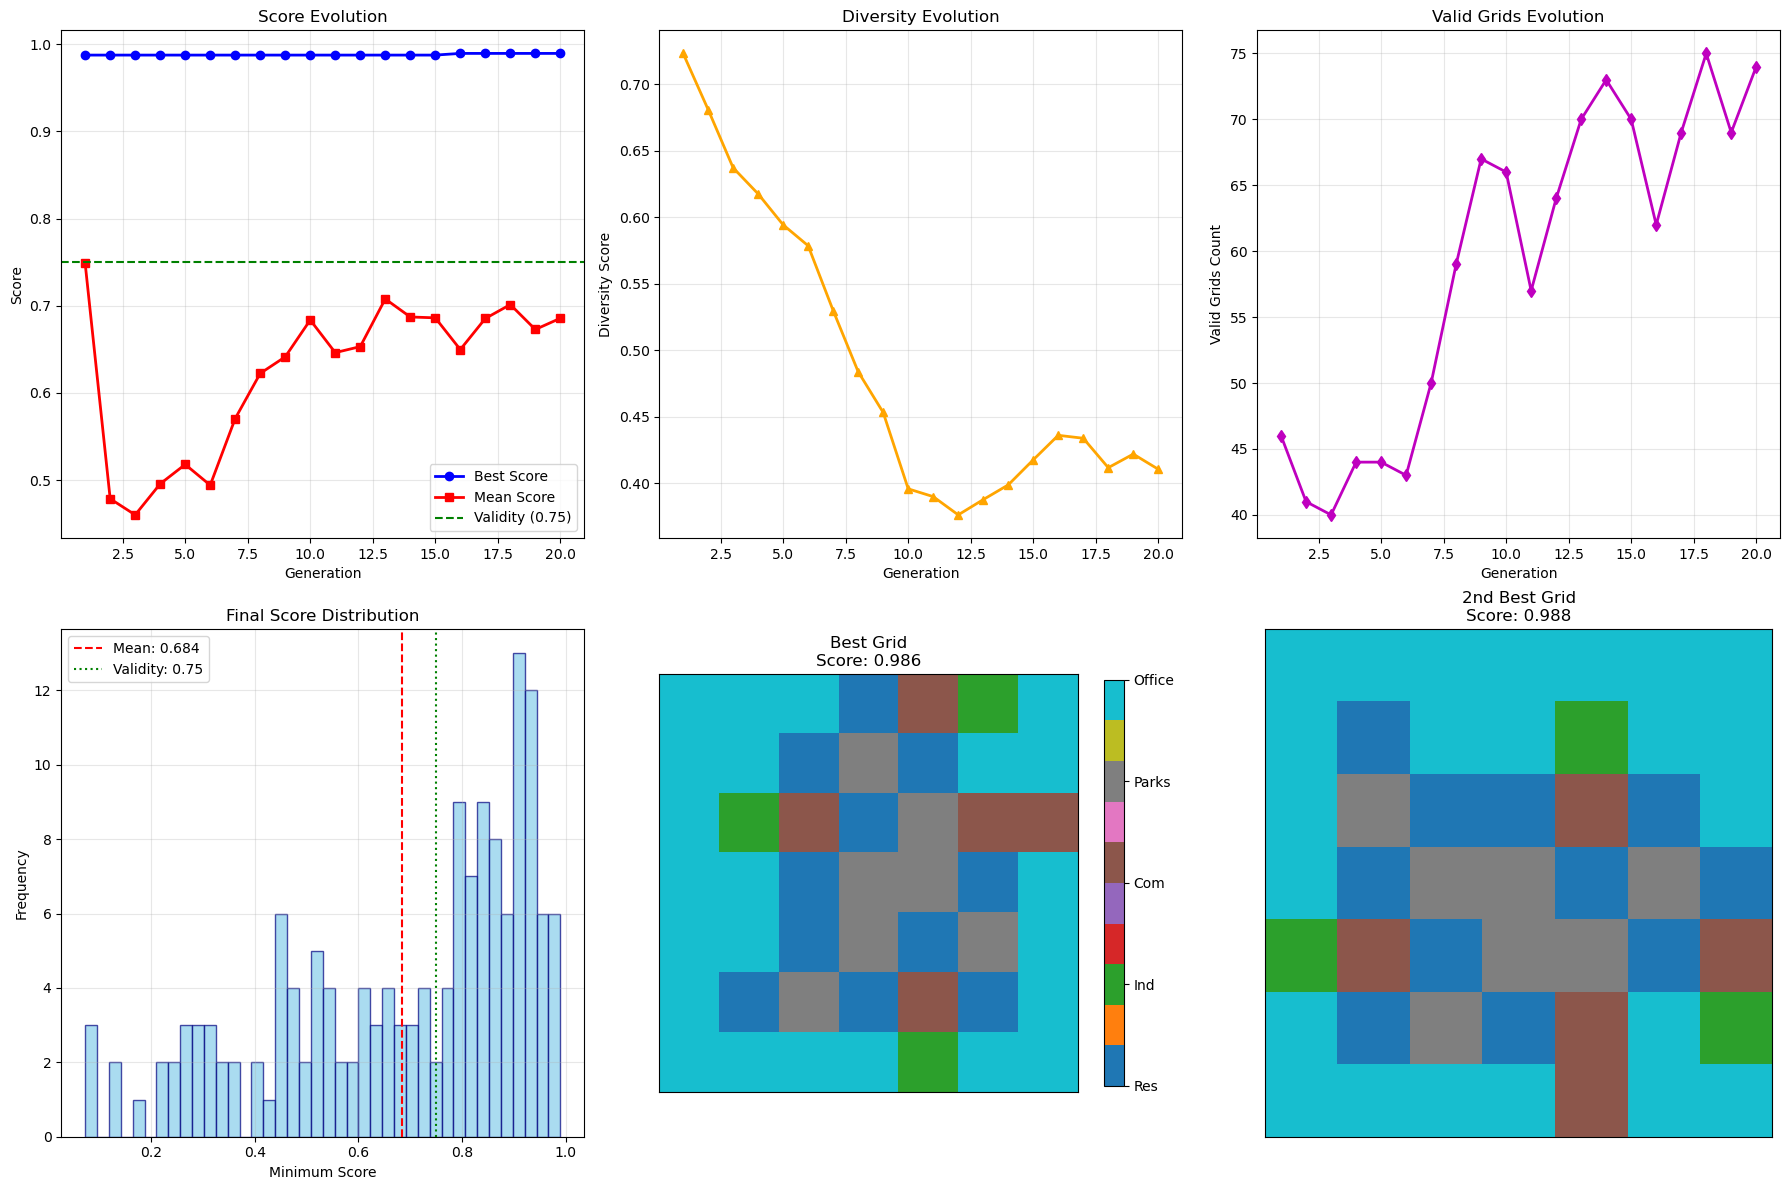


🏆 Visualizing Top 6 Generated Grids:


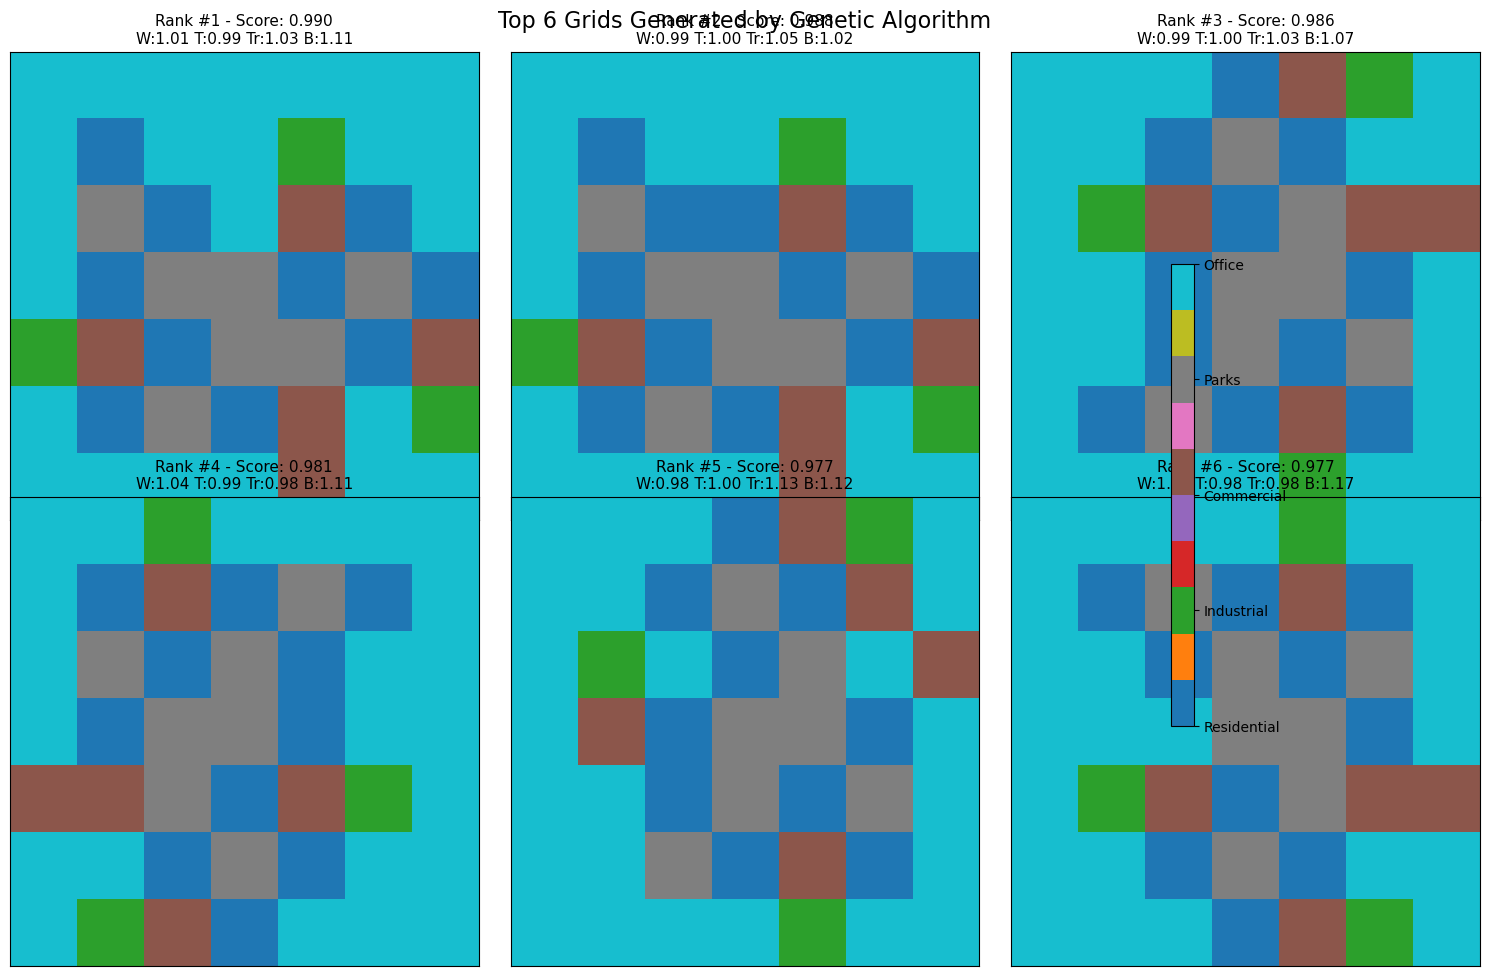


🧠 ADVISOR-SPECIFIC PERFORMANCE:
   Wellness:
     Mean: 0.7859
     Best: 1.1593
     ≥0.80: 98 grids
   Tax:
     Mean: 0.8659
     Best: 1.0150
     ≥0.80: 123 grids
   Transportation:
     Mean: 0.8927
     Best: 1.2803
     ≥0.80: 118 grids
   Business:
     Mean: 0.9590
     Best: 1.2407
     ≥0.80: 132 grids

💾 SAVING GENETIC ALGORITHM RESULTS:
✅ Saved genetic algorithm results:
   genetic_generated_grids_20251028_025412.npy ((154, 7, 7))
   genetic_predictions_20251028_025412.npy ((154, 4))
   genetic_best_grids_20251028_025412.npy ((100, 7, 7))
   genetic_algorithm_results_20251028_025412.json

🎉 GENETIC ALGORITHM GRID GENERATION COMPLETE!
✨ Key Achievements:
   • Generated 154 diverse, high-quality grids
   • Best score: 0.9896
   • 81 valid grids
   • Average diversity: 0.511
   • Used CNN Oracle models for accurate evaluation
   • Ready for submission building!


In [66]:
# 📊 ANALYSIS AND VISUALIZATION OF GENETIC ALGORITHM RESULTS
print("📊 Analysis and Visualization of Genetic Algorithm Results")
print("=" * 60)

if all_generated_grids is not None:
    print(f"📈 GENETIC ALGORITHM SUCCESS ANALYSIS:")
    print(f"   Total generated grids: {len(all_generated_grids)}")
    print(f"   Best score: {np.max(generated_min_scores):.4f}")
    print(f"   Mean score: {np.mean(generated_min_scores):.4f}")
    print(f"   Score std: {np.std(generated_min_scores):.4f}")
    
    # Compare with original dataset
    if 'min_scores' in locals():
        original_valid = np.sum(min_scores >= 0.75)
        generated_valid = np.sum(generated_min_scores >= 0.75)
        
        print(f"\n📊 COMPARISON WITH ORIGINAL DATASET:")
        print(f"   Original valid grids: {original_valid} ({original_valid/len(min_scores)*100:.2f}%)")
        print(f"   Generated valid grids: {generated_valid} ({generated_valid/len(generated_min_scores)*100:.2f}%)")
        print(f"   Improvement factor: {generated_valid/len(generated_min_scores) / (original_valid/len(min_scores)):.2f}x")
    
    # Score distribution analysis
    score_thresholds = [0.70, 0.75, 0.80, 0.85, 0.90]
    print(f"\n🎯 SCORE DISTRIBUTION:")
    for threshold in score_thresholds:
        count = np.sum(generated_min_scores >= threshold)
        percentage = count / len(generated_min_scores) * 100
        print(f"   ≥{threshold}: {count} grids ({percentage:.1f}%)")
    
    # Diversity analysis
    print(f"\n🌈 DIVERSITY ANALYSIS:")
    diversity_scores = []
    sample_size = min(100, len(all_generated_grids))  # Sample for speed
    sample_indices = np.random.choice(len(all_generated_grids), sample_size, replace=False)
    
    for i in range(sample_size):
        for j in range(i + 1, sample_size):
            grid1 = all_generated_grids[sample_indices[i]]
            grid2 = all_generated_grids[sample_indices[j]]
            diff_positions = np.sum(grid1 != grid2)
            diversity = diff_positions / 49.0
            diversity_scores.append(diversity)
    
    avg_diversity = np.mean(diversity_scores)
    print(f"   Average pairwise diversity: {avg_diversity:.3f}")
    print(f"   Diversity std: {np.std(diversity_scores):.3f}")
    print(f"   Min diversity: {np.min(diversity_scores):.3f}")
    print(f"   Max diversity: {np.max(diversity_scores):.3f}")
    
    # Evolution progress visualization
    if 'generation_stats' in locals():
        print(f"\n📈 Creating evolution progress visualization...")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Score evolution
        generations = [stat['generation'] for stat in generation_stats]
        best_scores = [stat['best_score'] for stat in generation_stats]
        mean_scores = [stat['mean_score'] for stat in generation_stats]
        
        axes[0, 0].plot(generations, best_scores, 'b-o', label='Best Score', linewidth=2)
        axes[0, 0].plot(generations, mean_scores, 'r-s', label='Mean Score', linewidth=2)
        axes[0, 0].axhline(y=0.75, color='green', linestyle='--', label='Validity (0.75)')
        axes[0, 0].set_xlabel('Generation')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].set_title('Score Evolution')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Diversity evolution
        diversity_scores = [stat['diversity'] for stat in generation_stats]
        axes[0, 1].plot(generations, diversity_scores, 'g-^', linewidth=2, color='orange')
        axes[0, 1].set_xlabel('Generation')
        axes[0, 1].set_ylabel('Diversity Score')
        axes[0, 1].set_title('Diversity Evolution')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Valid grids count
        valid_counts = [stat['valid_count'] for stat in generation_stats]
        axes[0, 2].plot(generations, valid_counts, 'm-d', linewidth=2)
        axes[0, 2].set_xlabel('Generation')
        axes[0, 2].set_ylabel('Valid Grids Count')
        axes[0, 2].set_title('Valid Grids Evolution')
        axes[0, 2].grid(True, alpha=0.3)
        
        # Plot 4: Final score distribution
        axes[1, 0].hist(generated_min_scores, bins=40, alpha=0.7, color='skyblue', edgecolor='navy')
        axes[1, 0].axvline(np.mean(generated_min_scores), color='red', linestyle='--', 
                          label=f'Mean: {np.mean(generated_min_scores):.3f}')
        axes[1, 0].axvline(0.75, color='green', linestyle=':', label='Validity: 0.75')
        axes[1, 0].set_xlabel('Minimum Score')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Final Score Distribution')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 5: Top grids visualization in axes[1, 1] and axes[1, 2]
        top_indices = np.argsort(generated_min_scores)[-3:]  # Top 3 grids
        
        # Show top 3 grids in axes[1, 1]
        axes[1, 1].axis('off')  # Turn off the main axis
        for i, idx in enumerate(top_indices):
            # Create small subplots within axes[1, 1]
            grid = all_generated_grids[idx]
            score = generated_min_scores[idx]
            
            # Use axes[1, 1] for the first grid
            if i == 0:
                im = axes[1, 1].imshow(grid, cmap='tab10', vmin=0, vmax=4)
                axes[1, 1].set_title(f'Best Grid\nScore: {score:.3f}', fontsize=12)
                axes[1, 1].set_xticks([])
                axes[1, 1].set_yticks([])
                axes[1, 1].axis('on')
        
        # Show comparison grids in axes[1, 2]
        if len(top_indices) > 1:
            # Show second best grid
            idx = top_indices[1]
            grid = all_generated_grids[idx]
            score = generated_min_scores[idx]
            
            im2 = axes[1, 2].imshow(grid, cmap='tab10', vmin=0, vmax=4)
            axes[1, 2].set_title(f'2nd Best Grid\nScore: {score:.3f}', fontsize=12)
            axes[1, 2].set_xticks([])
            axes[1, 2].set_yticks([])
        else:
            axes[1, 2].axis('off')
        
        # Add colorbar using the first image
        cbar = plt.colorbar(im, ax=axes[1, 1], shrink=0.8)
        cbar.set_ticks([0, 1, 2, 3, 4])
        cbar.set_ticklabels(['Res', 'Ind', 'Com', 'Parks', 'Office'])
        
        plt.tight_layout()
        plt.show()
        
        # Additional visualization: Top 6 grids in a separate figure
        print(f"\n🏆 Visualizing Top 6 Generated Grids:")
        top_6_indices = np.argsort(generated_min_scores)[-6:][::-1]  # Top 6, best first
        
        fig_grids, axes_grids = plt.subplots(2, 3, figsize=(15, 10))
        axes_grids = axes_grids.flatten()
        
        for i, idx in enumerate(top_6_indices):
            grid = all_generated_grids[idx]
            score = generated_min_scores[idx]
            predictions = generated_predictions[idx]
            
            im = axes_grids[i].imshow(grid, cmap='tab10', vmin=0, vmax=4)
            axes_grids[i].set_title(f'Rank #{i+1} - Score: {score:.3f}\n' + 
                                   f'W:{predictions[0]:.2f} T:{predictions[1]:.2f} '
                                   f'Tr:{predictions[2]:.2f} B:{predictions[3]:.2f}', 
                                   fontsize=11)
            axes_grids[i].set_xticks([])
            axes_grids[i].set_yticks([])
        
        # Add shared colorbar
        cbar_grids = plt.colorbar(im, ax=axes_grids, shrink=0.6, pad=0.1)
        cbar_grids.set_ticks([0, 1, 2, 3, 4])
        cbar_grids.set_ticklabels(['Residential', 'Industrial', 'Commercial', 'Parks', 'Office'])
        
        plt.suptitle('Top 6 Grids Generated by Genetic Algorithm', fontsize=16, y=0.98)
        plt.tight_layout()
        plt.show()
    
    # Advisor-specific analysis
    print(f"\n🧠 ADVISOR-SPECIFIC PERFORMANCE:")
    advisor_names = ["Wellness", "Tax", "Transportation", "Business"]
    for i, advisor in enumerate(advisor_names):
        advisor_scores = generated_predictions[:, i]
        print(f"   {advisor}:")
        print(f"     Mean: {np.mean(advisor_scores):.4f}")
        print(f"     Best: {np.max(advisor_scores):.4f}")
        print(f"     ≥0.80: {np.sum(advisor_scores >= 0.80)} grids")
    
    print(f"\n💾 SAVING GENETIC ALGORITHM RESULTS:")
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    
    # Save results
    np.save(f'data/generated_grids/genetic_generated_grids_{timestamp}.npy', all_generated_grids)
    np.save(f'data/generated_grids/genetic_predictions_{timestamp}.npy', generated_predictions)
    np.save(f'data/generated_grids/genetic_best_grids_{timestamp}.npy', best_generated_grids)
    
    # Save metadata
    metadata = {
        'timestamp': timestamp,
        'method': 'genetic_algorithm',
        'population_size': 500,
        'generations': 20,
        'total_grids': len(all_generated_grids),
        'best_score': float(np.max(generated_min_scores)),
        'mean_score': float(np.mean(generated_min_scores)),
        'valid_grids': int(np.sum(generated_min_scores >= 0.75)),
        'diversity_score': float(avg_diversity),
        'oracle_models_used': list(loaded_models.keys()) if 'loaded_models' in locals() else []
    }
    
    import json
    with open(f'data/generated_grids/genetic_algorithm_results_{timestamp}.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✅ Saved genetic algorithm results:")
    print(f"   genetic_generated_grids_{timestamp}.npy ({all_generated_grids.shape})")
    print(f"   genetic_predictions_{timestamp}.npy ({generated_predictions.shape})")
    print(f"   genetic_best_grids_{timestamp}.npy ({best_generated_grids.shape})")
    print(f"   genetic_algorithm_results_{timestamp}.json")
    
    print(f"\n🎉 GENETIC ALGORITHM GRID GENERATION COMPLETE!")
    print(f"✨ Key Achievements:")
    print(f"   • Generated {len(all_generated_grids)} diverse, high-quality grids")
    print(f"   • Best score: {np.max(generated_min_scores):.4f}")
    print(f"   • {np.sum(generated_min_scores >= 0.75)} valid grids")
    print(f"   • Average diversity: {avg_diversity:.3f}")
    print(f"   • Used CNN Oracle models for accurate evaluation")
    print(f"   • Ready for submission building!")
    
else:
    print("❌ No results to analyze - genetic algorithm did not run successfully")

In [ ]:
all_generated_grids.shape
grids[valid_mask].shape

(647, 7, 7)

In [ ]:
# 🏢 FILTER GRIDS: NO OFFICES IN CORNERS
print("🏢 Filtering grids with no offices in the four corners")
print("=" * 50)

def filter_no_corner_offices(grids):
    """Filter grids where none of the four corners are offices (district type 4)"""
    print(f"📊 Checking {len(grids)} grids for corner offices...")
    
    # Check all four corners: [0,0], [0,6], [6,0], [6,6]
    corner_office_mask = (
        (grids[:, 0, 0] == 4) |  # Top-left corner
        (grids[:, 0, 6] == 4) |  # Top-right corner  
        (grids[:, 6, 0] == 4) |  # Bottom-left corner
        (grids[:, 6, 6] == 4)    # Bottom-right corner
    )
    
    # Keep grids where NO corners are offices (invert the mask)
    no_corner_offices_mask = ~corner_office_mask
    
    filtered_grids = grids[no_corner_offices_mask]
    
    print(f"✅ Results:")
    print(f"   Original grids: {len(grids):,}")
    print(f"   Grids with corner offices: {np.sum(corner_office_mask):,}")
    print(f"   Grids WITHOUT corner offices: {len(filtered_grids):,}")
    print(f"   Filtering efficiency: {len(filtered_grids)/len(grids)*100:.1f}% kept")
    
    return filtered_grids, no_corner_offices_mask


filtered_generated_grids, filter_mask = filter_no_corner_offices(grids[valid_mask])

valid_grids = grids[valid_mask]

valid_grids[filter_mask]


🏢 Filtering grids with no offices in the four corners
📊 Checking 647 grids for corner offices...
✅ Results:
   Original grids: 647
   Grids with corner offices: 645
   Grids WITHOUT corner offices: 2
   Filtering efficiency: 0.3% kept


array([[[3., 4., 4., 1., 4., 4., 0.],
        [0., 3., 1., 0., 2., 2., 1.],
        [0., 3., 0., 0., 1., 4., 4.],
        [3., 2., 0., 2., 4., 1., 4.],
        [3., 0., 3., 4., 0., 3., 4.],
        [0., 1., 4., 1., 3., 0., 2.],
        [2., 4., 4., 2., 1., 1., 2.]],

       [[2., 1., 2., 4., 0., 4., 3.],
        [4., 0., 2., 4., 0., 4., 4.],
        [4., 2., 1., 2., 3., 0., 4.],
        [3., 4., 4., 0., 3., 1., 4.],
        [3., 3., 0., 0., 0., 2., 2.],
        [0., 2., 4., 3., 1., 4., 4.],
        [2., 4., 1., 4., 4., 2., 2.]]])

📊 Grid Position Frequency Analysis
🎯 Analyzing multiple grid datasets...

1️⃣  ORIGINAL VALID GRIDS:
🔍 Analyzing position frequencies for 647 original valid grids...
✅ Created frequency analysis DataFrame: (49, 9)
   49 positions × 5 district types
   Each frequency represents proportion (0.0 - 1.0)

📈 FREQUENCY SUMMARY:
   Residential : Mean=0.238, Std=0.187, Range=[0.000, 0.617]
   Industrial  : Mean=0.055, Std=0.068, Range=[0.000, 0.267]
   Commercial  : Mean=0.093, Std=0.116, Range=[0.002, 0.382]
   Parks       : Mean=0.168, Std=0.172, Range=[0.000, 0.560]
   Office      : Mean=0.446, Std=0.314, Range=[0.014, 0.964]

📋 First 10 positions from original valid grids:
  Position  Row  Col  Linear_Index  Residential  Industrial  Commercial  \
0  pos_0_0    0    0             0        0.012       0.011       0.005   
1  pos_0_1    0    1             1        0.025       0.122       0.020   
2  pos_0_2    0    2             2        0.107       0.161       0.026   
3  pos_0_3    0    3   

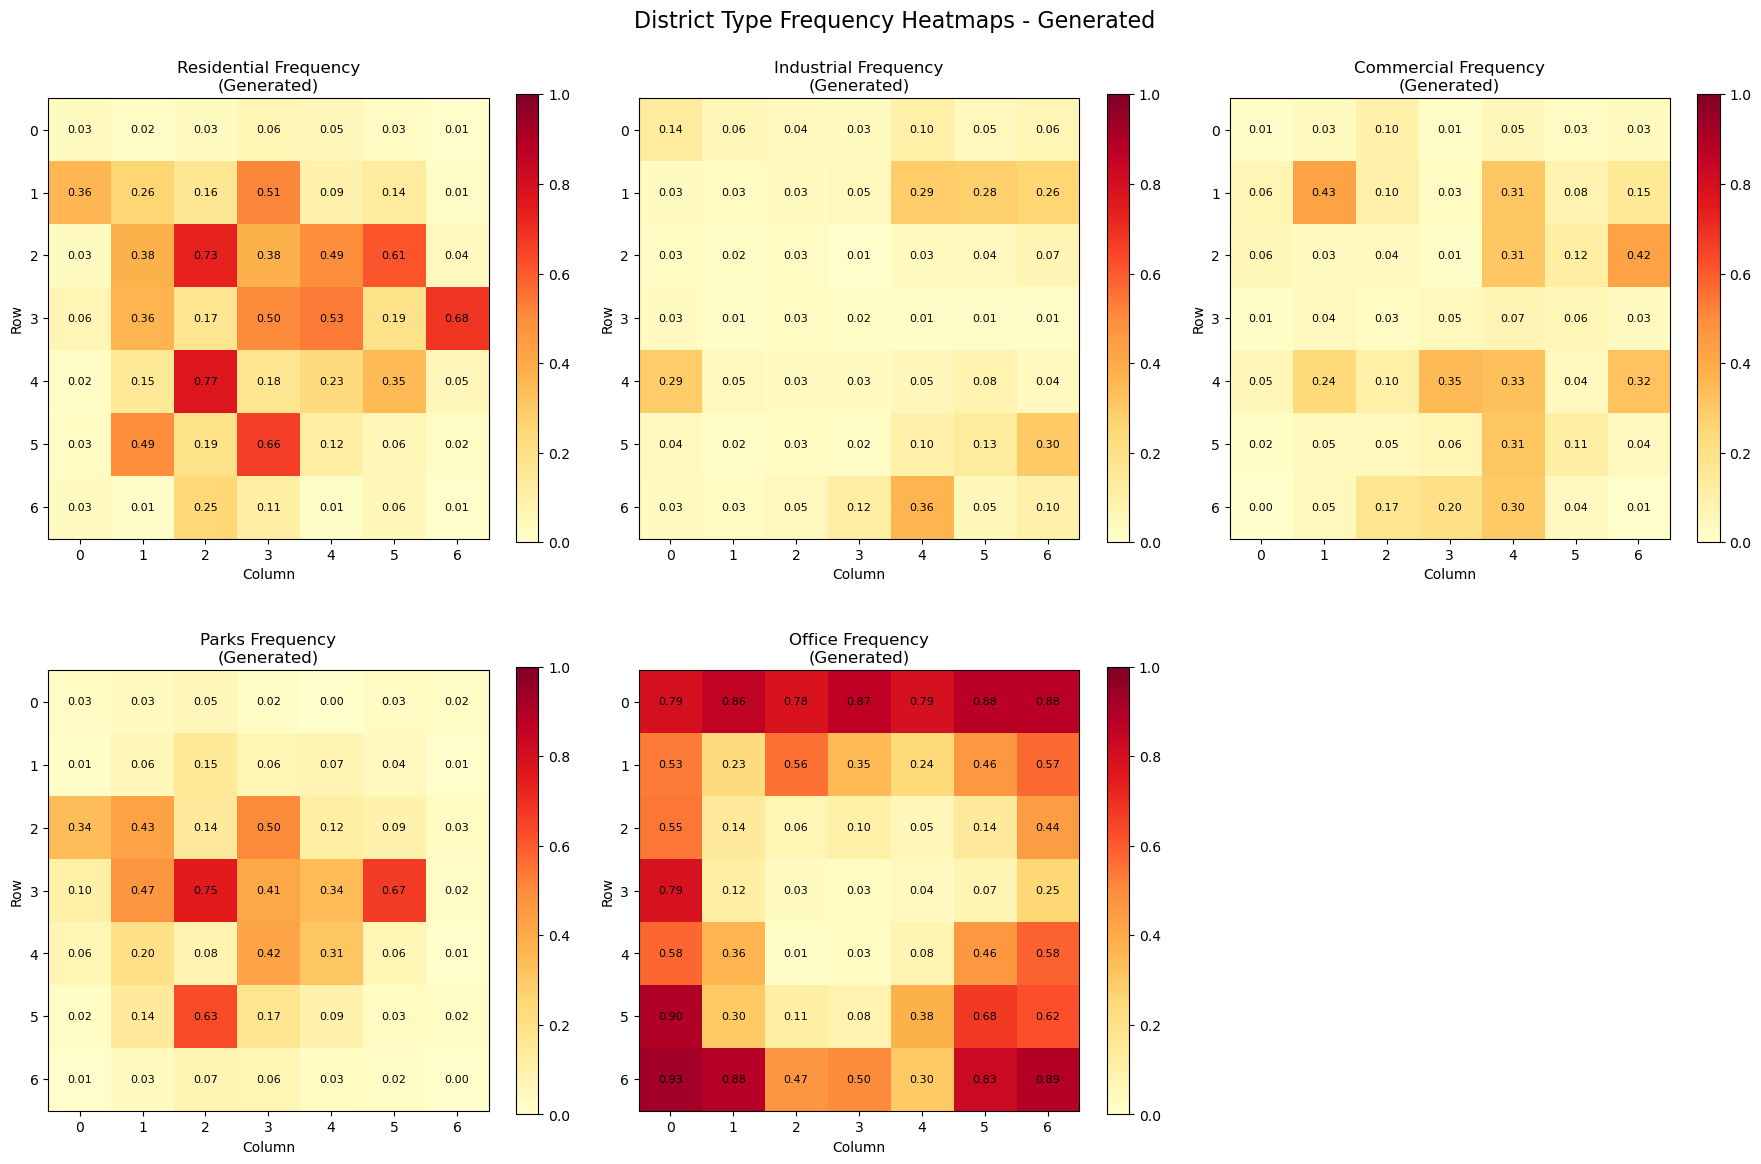


✅ POSITION FREQUENCY ANALYSIS COMPLETE!
💡 Use the DataFrames to analyze patterns:
   • df_original_valid: Original dataset valid grids
   • df_generated: Generated grids (if available)
   • df_filtered: Filtered grids (if available)
📊 Each DataFrame has 49 rows (positions) × 9 columns (4 info + 5 district frequencies)


In [110]:
# 📊 GRID POSITION FREQUENCY ANALYSIS
print("📊 Grid Position Frequency Analysis")
print("=" * 45)

def analyze_grid_position_frequencies(grids, grid_name="grids"):
    """
    Create a DataFrame with 49 rows (one per grid position) and 5 columns (one per district type)
    showing the frequency of each district type at each position
    """
    print(f"🔍 Analyzing position frequencies for {len(grids):,} {grid_name}...")
    
    # District type names
    district_types = ['Residential', 'Industrial', 'Commercial', 'Parks', 'Office']
    
    # Initialize frequency data
    position_frequencies = []
    
    # Process each position (7x7 = 49 positions)
    for i in range(7):
        for j in range(7):
            position_name = f"pos_{i}_{j}"  # Row i, Column j
            position_index = i * 7 + j  # Linear index (0-48)
            
            # Extract values at this position across all grids
            position_values = grids[:, i, j]
            
            # Count frequency of each district type
            frequencies = {}
            total_grids = len(grids)
            
            for district_type in range(5):  # 0-4 for the 5 district types
                count = np.sum(position_values == district_type)
                frequency = count / total_grids
                frequencies[district_types[district_type]] = frequency
            
            # Add position info
            frequencies['Position'] = position_name
            frequencies['Row'] = i
            frequencies['Col'] = j
            frequencies['Linear_Index'] = position_index
            
            position_frequencies.append(frequencies)
    
    # Create DataFrame
    df = pd.DataFrame(position_frequencies)
    
    # Reorder columns for better readability
    column_order = ['Position', 'Row', 'Col', 'Linear_Index', 
                   'Residential', 'Industrial', 'Commercial', 'Parks', 'Office']
    df = df[column_order]
    
    print(f"✅ Created frequency analysis DataFrame: {df.shape}")
    print(f"   49 positions × {len(district_types)} district types")
    print(f"   Each frequency represents proportion (0.0 - 1.0)")
    
    # Summary statistics
    print(f"\n📈 FREQUENCY SUMMARY:")
    for district in district_types:
        mean_freq = df[district].mean()
        std_freq = df[district].std()
        min_freq = df[district].min()
        max_freq = df[district].max()
        
        print(f"   {district:<12}: Mean={mean_freq:.3f}, Std={std_freq:.3f}, "
              f"Range=[{min_freq:.3f}, {max_freq:.3f}]")
    
    return df

# Example usage - analyze different grid sets
print("🎯 Analyzing multiple grid datasets...\n")

# 1. Analyze original valid grids
if 'grids' in locals() and 'valid_mask' in locals():
    print("1️⃣  ORIGINAL VALID GRIDS:")
    valid_grids = grids[valid_mask]
    df_original_valid = analyze_grid_position_frequencies(valid_grids, "original valid grids")
    
    print(f"\n📋 First 10 positions from original valid grids:")
    print(df_original_valid.head(10).round(3))

# 2. Analyze generated grids if available
if 'all_generated_grids' in locals() and all_generated_grids is not None:
    print(f"\n2️⃣  GENERATED GRIDS:")
    df_generated = analyze_grid_position_frequencies(all_generated_grids, "generated grids")
    
    print(f"\n📋 First 10 positions from generated grids:")
    print(df_generated.head(10).round(3))

# 3. Analyze original non valid grids
if 'grids' in locals() and 'valid_mask' in locals():
    print("1️⃣  ORIGINAL VALID GRIDS:")
    invalid_grids = grids[~valid_mask]
    df_original_invalid = analyze_grid_position_frequencies(invalid_grids, "original valid grids")
    
    print(f"\n📋 First 10 positions from original valid grids:")
    print(df_original_invalid.head(10).round(3))

# 4. Create a comprehensive comparison if we have multiple datasets
datasets_available = []
if 'df_original_valid' in locals():
    datasets_available.append(('Original Valid', df_original_valid))
if 'df_generated' in locals():
    datasets_available.append(('Generated', df_generated))
if 'df_original_invalid' in locals():
    datasets_available.append(('Invalid', df_generated))

if len(datasets_available) > 1:
    print(f"\n🔄 DATASET COMPARISON:")
    print("="*60)
    
    # Compare corner positions (most interesting)
    corner_positions = [(0, 0), (0, 6), (6, 0), (6, 6)]  # Four corners
    edge_positions = [(0, 3), (3, 0), (3, 6), (6, 3)]   # Mid-edges
    center_position = [(3, 3)]                            # Center
    
    positions_to_compare = {
        'Corners': corner_positions,
        'Edges': edge_positions, 
        'Center': center_position
    }
    
    for position_group, positions in positions_to_compare.items():
        print(f"\n📍 {position_group.upper()} COMPARISON:")
        
        for pos_row, pos_col in positions:
            linear_idx = pos_row * 7 + pos_col
            print(f"\n   Position ({pos_row},{pos_col}) - Linear Index {linear_idx}:")
            
            for dataset_name, df in datasets_available:
                row_data = df[df['Linear_Index'] == linear_idx].iloc[0]
                print(f"     {dataset_name:<15}: Res={row_data['Residential']:.2f} "
                      f"Ind={row_data['Industrial']:.2f} Com={row_data['Commercial']:.2f} "
                      f"Parks={row_data['Parks']:.2f} Office={row_data['Office']:.2f}")

# 5. Generate heatmaps for visualization
print(f"\n🎨 Creating position frequency heatmaps...")

def create_position_heatmap(df, district_type, title_suffix=""):
    """Create a 7x7 heatmap showing frequency of a district type at each position"""
    heatmap_data = np.zeros((7, 7))
    
    for _, row in df.iterrows():
        i, j = int(row['Row']), int(row['Col'])
        heatmap_data[i, j] = row[district_type]
    
    return heatmap_data

# Create heatmaps for the first available dataset
if datasets_available:

    """
    selected_dataset =
    1: Valid
    2: Generated
    3: Invalid
    """
    selected_dataset = 1

    dataset_name, df_to_plot = datasets_available[selected_dataset]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    district_types = ['Residential', 'Industrial', 'Commercial', 'Parks', 'Office']
    
    for idx, district in enumerate(district_types):
        heatmap_data = create_position_heatmap(df_to_plot, district)
        
        im = axes[idx].imshow(heatmap_data, cmap='YlOrRd', vmin=0, vmax=1)
        axes[idx].set_title(f'{district} Frequency\n({dataset_name})', fontsize=12)
        axes[idx].set_xlabel('Column')
        axes[idx].set_ylabel('Row')
        
        # Add frequency values as text
        for i in range(7):
            for j in range(7):
                text = axes[idx].text(j, i, f'{heatmap_data[i, j]:.2f}',
                                    ha="center", va="center", color="black", fontsize=8)
        
        # Add colorbar
        plt.colorbar(im, ax=axes[idx], shrink=0.8)
    
    # Remove the extra subplot
    fig.delaxes(axes[5])
    
    plt.suptitle(f'District Type Frequency Heatmaps - {dataset_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

print(f"\n✅ POSITION FREQUENCY ANALYSIS COMPLETE!")
print(f"💡 Use the DataFrames to analyze patterns:")
print(f"   • df_original_valid: Original dataset valid grids")
print(f"   • df_generated: Generated grids (if available)")  
print(f"   • df_filtered: Filtered grids (if available)")
print(f"📊 Each DataFrame has 49 rows (positions) × 9 columns (4 info + 5 district frequencies)")

🎯 Generating grids without unwanted biases
🔧 Generating 5000 grids without unwanted biases...
   🔍 Scanning 647 seed grids for grids without unwanted biases...
   ✅ Found 0 existing grids without unwanted biases
   🧬 Generating 5000 additional grids through mutation...
     Generated 10/5000 grids...
     Generated 20/5000 grids...
     Generated 30/5000 grids...
     Generated 20/5000 grids...
     Generated 30/5000 grids...
     Generated 40/5000 grids...
     Generated 50/5000 grids...
     Generated 60/5000 grids...
     Generated 40/5000 grids...
     Generated 50/5000 grids...
     Generated 60/5000 grids...
     Generated 70/5000 grids...
     Generated 70/5000 grids...
     Generated 80/5000 grids...
     Generated 90/5000 grids...
     Generated 80/5000 grids...
     Generated 90/5000 grids...
     Generated 100/5000 grids...
     Generated 100/5000 grids...
     Generated 110/5000 grids...
     Generated 120/5000 grids...
     Generated 110/5000 grids...
     Generated 120/50

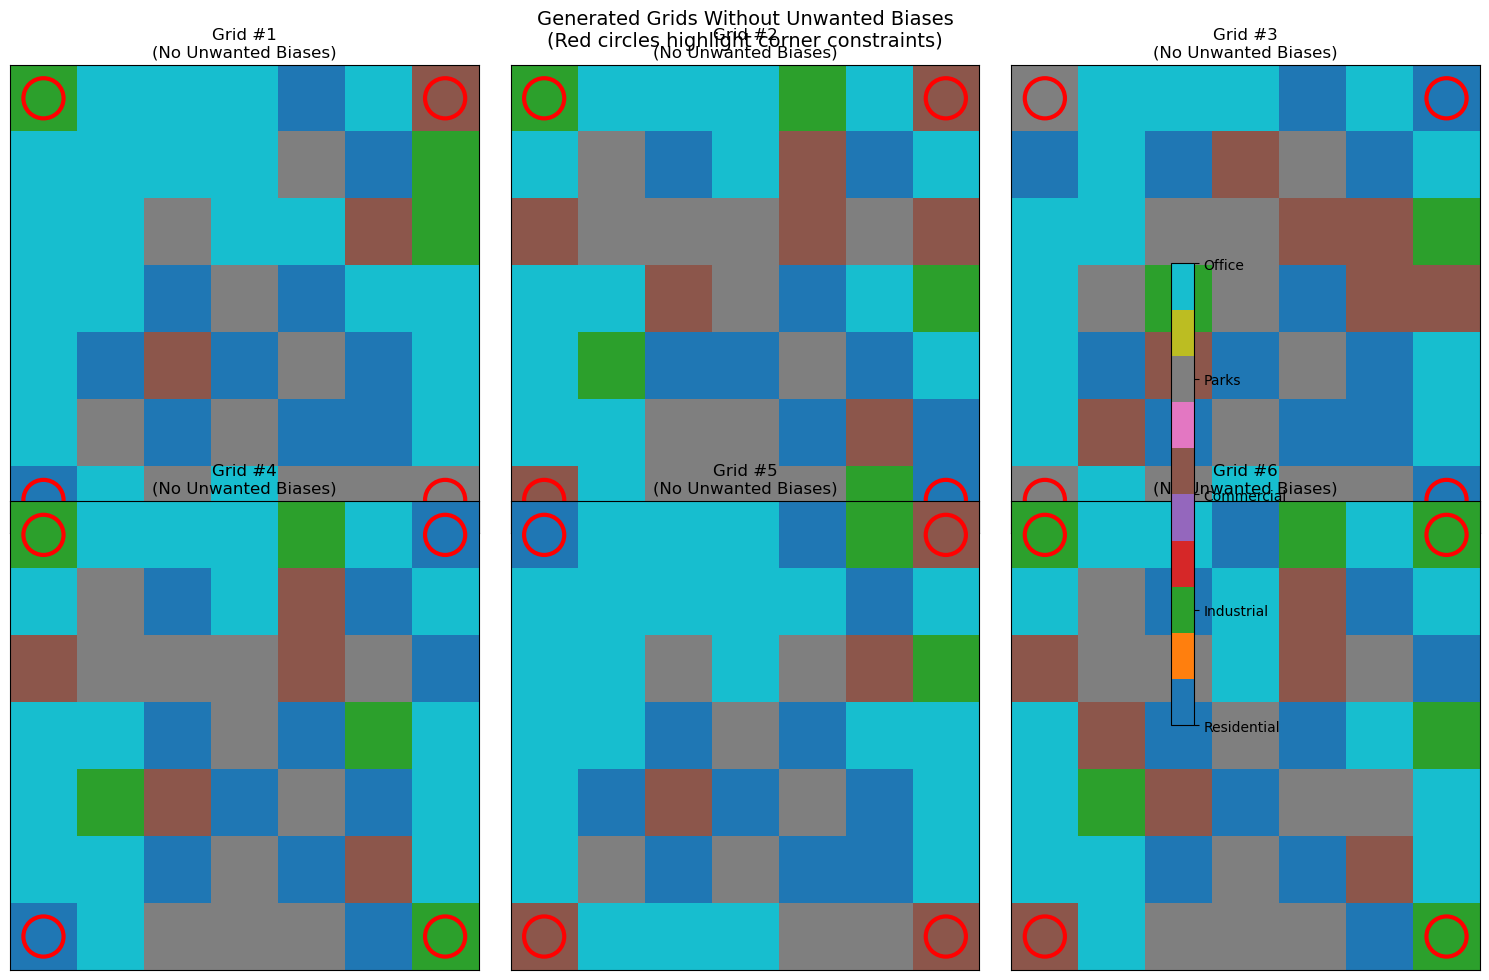


🔮 Evaluating with CNN Oracle...
   🚀 Evaluating 978 grids with CNN Oracles...
🚛 Creating transportation predictions for 978 grids...
🚛 Creating transportation predictions for 978 grids...
🚛 Creating transportation predictions for 978 grids...
🚛 Creating transportation predictions for 978 grids...
🚛 Creating transportation predictions for 978 grids...
🚛 Creating transportation predictions for 978 grids...
   ✅ Predictions complete: (978, 4)
📊 ORACLE EVALUATION RESULTS:
   Best score: 0.8344
   Mean score: 0.5086
   Valid (≥0.75): 36
   High-quality (≥0.80): 6
   🚀 Evaluating 100 grids with CNN Oracles...
🚛 Creating transportation predictions for 100 grids...
🚛 Creating transportation predictions for 100 grids...
🚛 Creating transportation predictions for 100 grids...
🚛 Creating transportation predictions for 100 grids...
🚛 Creating transportation predictions for 978 grids...
   ✅ Predictions complete: (978, 4)
📊 ORACLE EVALUATION RESULTS:
   Best score: 0.8344
   Mean score: 0.5086
   V

In [113]:
from collections import Counter
from matplotlib.patches import Rectangle

# 🎯 GENERATE GRIDS WITHOUT UNWANTED BIASES
print("🎯 Generating grids without unwanted biases")
print("=" * 55)

def has_unwanted_bias(grid):
    """Check if grid has unwanted biases including corner offices and specific residential/parks patterns"""
    # Check all four corner positions for offices: [0,0], [0,6], [6,0], [6,6]
    corner_offices = (
        grid[0, 0] == 4 or  # Top-left corner
        grid[0, 6] == 4 or  # Top-right corner  
        grid[6, 0] == 4 or  # Bottom-left corner
        grid[6, 6] == 4     # Bottom-right corner
    )
    
    # Check for unwanted residential patterns at specific positions
    unwanted_residential = (
        grid[2, 2] == 0 or
        grid[2, 4] == 0 or
        grid[3, 5] == 0 or
        grid[6, 3] == 0 
    )
    
    # Check for unwanted parks patterns at specific positions
    unwanted_parks = (
        grid[2, 3] == 0 or
        grid[2, 5] == 0 or
        grid[5, 3] == 0
    )
    
    return corner_offices or unwanted_residential or unwanted_parks

def generate_no_corner_office_grids(seed_grids, target_count=5000):
    """Generate grids without unwanted biases using mutation strategy"""
    print(f"🔧 Generating {target_count} grids without unwanted biases...")
    
    # Start with seed grids that already have no corner offices
    no_corner_grids = []
    
    # First, find existing grids without unwanted biases
    print(f"   🔍 Scanning {len(seed_grids)} seed grids for grids without unwanted biases...")
    for i, grid in enumerate(seed_grids):
        if not has_unwanted_bias(grid):
            no_corner_grids.append(grid.copy())
            if len(no_corner_grids) >= target_count:
                break
    
    print(f"   ✅ Found {len(no_corner_grids)} existing grids without unwanted biases")
    
    # If we need more grids, generate them through mutation
    if len(no_corner_grids) < target_count:
        needed = target_count - len(no_corner_grids)
        print(f"   🧬 Generating {needed} additional grids through mutation...")
        
        # Use existing bias-free grids as templates, or best seed grids
        if len(no_corner_grids) > 0:
            templates = no_corner_grids
        else:
            # Use top scoring seed grids as templates
            if 'valid_grids' in locals():
                templates = valid_grids[:20]  # Top 20 valid grids
            else:
                templates = seed_grids[:20]  # Top 20 seed grids
        
        attempts = 0
        max_attempts = needed * 20  # Allow multiple attempts per target
        
        while len(no_corner_grids) < target_count and attempts < max_attempts:
            # Select random template
            template = templates[np.random.randint(0, len(templates))]
            
            # Create mutated version
            mutated_grid = template.copy()
            
            # Apply mutations to any position (unwanted biases will be corrected afterward)
            n_mutations = np.random.randint(3, 8)  # 3-8 mutations
            
            for _ in range(n_mutations):
                # Select random position anywhere on grid
                i = np.random.randint(0, 7)  # Rows 0-6 (any position)
                j = np.random.randint(0, 7)  # Cols 0-6 (any position)
                
                # Mutation strategies
                mutation_type = np.random.choice(['random_district', 'neighbor_swap', 'cluster_expand'])
                
                if mutation_type == 'random_district':
                    # Change to random district type
                    mutated_grid[i, j] = np.random.randint(0, 5)
                    
                elif mutation_type == 'neighbor_swap':
                    # Swap with random valid neighbor
                    neighbors = []
                    for di in [-1, 0, 1]:
                        for dj in [-1, 0, 1]:
                            ni, nj = i + di, j + dj
                            if 0 <= ni < 7 and 0 <= nj < 7 and (ni != i or nj != j):
                                neighbors.append((ni, nj))
                    
                    if neighbors:
                        ni, nj = neighbors[np.random.randint(len(neighbors))]
                        mutated_grid[i, j], mutated_grid[ni, nj] = mutated_grid[ni, nj], mutated_grid[i, j]
                        
                elif mutation_type == 'cluster_expand':
                    # Change to most common neighbor type
                    neighbor_values = []
                    for di in [-1, 0, 1]:
                        for dj in [-1, 0, 1]:
                            ni, nj = i + di, j + dj
                            if 0 <= ni < 7 and 0 <= nj < 7 and (ni != i or nj != j):
                                neighbor_values.append(mutated_grid[ni, nj])
                    
                    if neighbor_values:
                        most_common = Counter(neighbor_values).most_common(1)[0][0]
                        mutated_grid[i, j] = most_common
            
            # Correct unwanted biases: remove offices from corners and fix problematic patterns
            # Four corners: [0,0], [0,6], [6,0], [6,6] - no offices allowed
            if mutated_grid[0, 0] == 4:  # Top-left corner
                mutated_grid[0, 0] = np.random.choice([0, 1, 2, 3])  # No office
            if mutated_grid[0, 6] == 4:  # Top-right corner
                mutated_grid[0, 6] = np.random.choice([0, 1, 2, 3])  # No office
            if mutated_grid[6, 0] == 4:  # Bottom-left corner
                mutated_grid[6, 0] = np.random.choice([0, 1, 2, 3])  # No office
            if mutated_grid[6, 6] == 4:  # Bottom-right corner
                mutated_grid[6, 6] = np.random.choice([0, 1, 2, 3])  # No office
            
            # Verify no unwanted biases and add if unique
            if not has_unwanted_bias(mutated_grid):
                # Check for uniqueness
                is_unique = True
                for existing_grid in no_corner_grids:
                    if np.array_equal(mutated_grid, existing_grid):
                        is_unique = False
                        break
                
                if is_unique:
                    no_corner_grids.append(mutated_grid)
                    if len(no_corner_grids) % 10 == 0:
                        print(f"     Generated {len(no_corner_grids)}/{target_count} grids...")
            
            attempts += 1
        
        print(f"   ✅ Generated {len(no_corner_grids)} total grids without unwanted biases")
    
    return np.array(no_corner_grids[:target_count])

# Generate the grids
if 'valid_grids' in locals():
    no_corner_office_grids = generate_no_corner_office_grids(valid_grids, target_count=5000)
    seed_source = "valid grids"
elif 'grids' in locals():
    no_corner_office_grids = generate_no_corner_office_grids(grids, target_count=5000)
    seed_source = "all grids"
else:
    print("❌ No seed grids available")
    no_corner_office_grids = None

if no_corner_office_grids is not None:
    print(f"\n📊 RESULTS:")
    print(f"   Generated grids: {len(no_corner_office_grids)}")
    print(f"   Source: {seed_source}")
    
    # Verify all grids have no unwanted biases
    verification_passed = 0
    for i, grid in enumerate(no_corner_office_grids):
        if not has_unwanted_bias(grid):
            verification_passed += 1
        else:
            print(f"   ⚠️  Grid {i} still has unwanted biases!")
    
    print(f"   Verification: {verification_passed}/{len(no_corner_office_grids)} grids pass (no unwanted biases)")
    
    # Analyze district composition
    print(f"\n📈 DISTRICT COMPOSITION ANALYSIS:")
    district_names = ['Residential', 'Industrial', 'Commercial', 'Parks', 'Office']
    
    total_positions = len(no_corner_office_grids) * 49  # 7x7 per grid
    for district_type in range(5):
        count = np.sum(no_corner_office_grids == district_type)
        percentage = count / total_positions * 100
        print(f"   {district_names[district_type]:<12}: {count:4d} positions ({percentage:5.1f}%)")
    
    # Analyze corner composition specifically
    print(f"\n📐 CORNER COMPOSITION ANALYSIS:")
    corner_positions = []
    for grid in no_corner_office_grids:
        # Extract all four corner positions
        corners = [grid[0, 0], grid[0, 6], grid[6, 0], grid[6, 6]]
        corner_positions.extend(corners)
    
    corner_positions = np.array(corner_positions)
    total_corners = len(corner_positions)
    
    print(f"   Total corner positions: {total_corners}")
    for district_type in range(5):
        count = np.sum(corner_positions == district_type)
        percentage = count / total_corners * 100
        print(f"   {district_names[district_type]:<12}: {count:4d} positions ({percentage:5.1f}%)")
    
    # Visualize a few examples
    print(f"\n🎨 Visualizing first 6 generated grids:")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(min(6, len(no_corner_office_grids))):
        grid = no_corner_office_grids[i]
        
        im = axes[i].imshow(grid, cmap='tab10', vmin=0, vmax=4)
        axes[i].set_title(f'Grid #{i+1}\n(No Unwanted Biases)', fontsize=12)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
        # Highlight corners with red circles to show constraint areas
        from matplotlib.patches import Circle
        # Top-left corner
        axes[i].add_patch(Circle((0, 0), 0.3, fill=False, edgecolor='red', linewidth=3))
        # Top-right corner
        axes[i].add_patch(Circle((6, 0), 0.3, fill=False, edgecolor='red', linewidth=3))
        # Bottom-left corner
        axes[i].add_patch(Circle((0, 6), 0.3, fill=False, edgecolor='red', linewidth=3))
        # Bottom-right corner
        axes[i].add_patch(Circle((6, 6), 0.3, fill=False, edgecolor='red', linewidth=3))
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes, shrink=0.6, pad=0.1)
    cbar.set_ticks([0, 1, 2, 3, 4])
    cbar.set_ticklabels(['Residential', 'Industrial', 'Commercial', 'Parks', 'Office'])
    
    plt.suptitle('Generated Grids Without Unwanted Biases\n(Red circles highlight corner constraints)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Evaluate with Oracle if available
    if 'oracle_predictor' in locals() and oracle_predictor is not None:
        print(f"\n🔮 Evaluating with CNN Oracle...")
        
        no_corner_predictions = oracle_predictor.predict_all_advisors(no_corner_office_grids)
        no_corner_min_scores = np.min(no_corner_predictions, axis=1)
        
        print(f"📊 ORACLE EVALUATION RESULTS:")
        print(f"   Best score: {np.max(no_corner_min_scores):.4f}")
        print(f"   Mean score: {np.mean(no_corner_min_scores):.4f}")
        print(f"   Valid (≥0.75): {np.sum(no_corner_min_scores >= 0.75)}")
        print(f"   High-quality (≥0.80): {np.sum(no_corner_min_scores >= 0.80)}")
        
        # Compare with original valid grids performance
        if 'valid_grids' in locals() and len(valid_grids) > 0:
            sample_valid = valid_grids[:100]  # Sample for comparison
            sample_valid_predictions = oracle_predictor.predict_all_advisors(sample_valid)
            sample_valid_min_scores = np.min(sample_valid_predictions, axis=1)
            
            print(f"\n📊 COMPARISON WITH VALID GRIDS SAMPLE:")
            print(f"   No-corner mean score: {np.mean(no_corner_min_scores):.4f}")
            print(f"   Valid grids mean score: {np.mean(sample_valid_min_scores):.4f}")
            print(f"   Performance ratio: {np.mean(no_corner_min_scores) / np.mean(sample_valid_min_scores):.3f}")
    
    # Save results
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    filename = f'data/generated_grids/no_corner_office_grids_{timestamp}.npy'
    np.save(filename, no_corner_office_grids)
    
    print(f"\n💾 SAVED RESULTS:")
    print(f"   File: {filename}")
    print(f"   Shape: {no_corner_office_grids.shape}")
    
    print(f"\n✅ BIAS-FREE GRID GENERATION COMPLETE!")
    print(f"🎯 Generated {len(no_corner_office_grids)} diverse grids without unwanted biases")
    print(f"📋 Ready for submission or further analysis")

else:
    print("❌ Grid generation failed - no seed grids available")

In [114]:
df_min_scores = pd.DataFrame(no_corner_min_scores)
df_predictions = pd.DataFrame(no_corner_predictions)

indexes = df_min_scores[df_min_scores[0]>=0.75].index

df_predictions.loc[indexes]

,0,1,2,3
0,0.791492,0.787467,0.838268,1.067497
33,0.941174,0.825941,0.883641,0.803818
38,0.810581,0.832344,0.775087,0.836721
47,0.807986,0.755048,0.846048,0.884193
52,0.824471,0.814721,0.913655,1.084602
67,0.764260,0.756687,0.763042,1.103727
70,0.756669,0.825631,0.909279,1.001945
92,0.821187,0.782837,0.830231,0.848304
133,0.834485,0.814120,0.822341,0.759723
194,0.791282,0.806032,0.795899,1.115263


In [115]:
selected = 973
no_corner_office_grids[selected]

array([[2., 4., 4., 4., 0., 4., 1.],
       [4., 4., 0., 2., 3., 0., 4.],
       [4., 4., 3., 3., 2., 2., 1.],
       [4., 4., 1., 3., 0., 2., 1.],
       [4., 0., 2., 0., 3., 0., 4.],
       [4., 3., 0., 3., 0., 0., 4.],
       [2., 4., 3., 4., 3., 3., 0.]])

In [118]:
# 🔍 CHECK IF NEW GRIDS ARE ALREADY IN ORIGINAL DATASET
print("🔍 Checking if generated grids are novel (not in original dataset)")
print("=" * 65)

def check_grid_novelty(new_grids, original_grids, batch_size=1000):
    """
    Check if generated grids are novel by comparing against original dataset
    Uses batched processing for memory efficiency with large datasets
    """
    print(f"🔎 Comparing {len(new_grids):,} new grids against {len(original_grids):,} original grids...")
    
    duplicates_found = []
    duplicate_indices = []
    novel_grids = []
    novel_indices = []
    
    # Process in batches to handle memory efficiently
    n_batches = (len(new_grids) + batch_size - 1) // batch_size
    
    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(new_grids))
        batch_grids = new_grids[start_idx:end_idx]
        
        print(f"   Processing batch {batch_idx + 1}/{n_batches} "
              f"(grids {start_idx}-{end_idx-1})...")
        
        for i, new_grid in enumerate(batch_grids):
            global_idx = start_idx + i
            is_duplicate = False
            
            # Compare against all original grids
            for j, original_grid in enumerate(original_grids):
                if np.array_equal(new_grid, original_grid):
                    duplicates_found.append((global_idx, j, new_grid.copy()))
                    duplicate_indices.append(global_idx)
                    is_duplicate = True
                    break  # Found duplicate, no need to check further
            
            if not is_duplicate:
                novel_grids.append(new_grid.copy())
                novel_indices.append(global_idx)
    
    return {
        'duplicates_found': duplicates_found,
        'duplicate_indices': duplicate_indices, 
        'novel_grids': np.array(novel_grids) if novel_grids else np.array([]),
        'novel_indices': novel_indices,
        'total_duplicates': len(duplicates_found),
        'total_novel': len(novel_grids)
    }

# Check novelty of our generated grids against VALID grids only (much faster and more relevant)
if 'no_corner_office_grids' in locals() and 'valid_grids' in locals():
    print("🎯 Checking novelty of bias-free generated grids against VALID grids...")
    print(f"   This is more efficient and relevant than checking all 500K grids")
    
    novelty_results = check_grid_novelty(
        new_grids=no_corner_office_grids,
        original_grids=valid_grids,  # Only check against valid grids (much smaller set)
        batch_size=100  # Smaller batch size for faster processing
    )
    
    # Extract results
    duplicates_found = novelty_results['duplicates_found']
    duplicate_indices = novelty_results['duplicate_indices']
    novel_grids = novelty_results['novel_grids']
    novel_indices = novelty_results['novel_indices']
    total_duplicates = novelty_results['total_duplicates']
    total_novel = novelty_results['total_novel']
    
    print(f"\n📊 NOVELTY ANALYSIS RESULTS:")
    print(f"   Total generated grids: {len(no_corner_office_grids):,}")
    print(f"   Duplicates found: {total_duplicates:,} ({total_duplicates/len(no_corner_office_grids)*100:.2f}%)")
    print(f"   Novel grids: {total_novel:,} ({total_novel/len(no_corner_office_grids)*100:.2f}%)")
    
    if total_duplicates > 0:
        print(f"\n⚠️  DUPLICATE DETAILS:")
        print(f"   Found {total_duplicates} grids that already exist in original dataset")
        
        # Show first few duplicates for inspection
        max_show = min(5, len(duplicates_found))
        print(f"   First {max_show} duplicates:")
        for i in range(max_show):
            new_idx, orig_idx, _ = duplicates_found[i]
            print(f"     Generated grid #{new_idx} = Original grid #{orig_idx}")
        
        if len(duplicates_found) > max_show:
            print(f"     ... and {len(duplicates_found) - max_show} more duplicates")
    
    if total_novel > 0:
        print(f"\n✅ NOVEL GRIDS:")
        print(f"   Successfully generated {total_novel} completely new grids!")
        print(f"   These grids don't exist in the original 500K dataset")
        
        # Evaluate novel grids with Oracle if available
        if 'oracle_predictor' in locals() and oracle_predictor is not None and len(novel_grids) > 0:
            print(f"\n🔮 Evaluating {len(novel_grids)} novel grids with CNN Oracle...")
            
            # Sample for evaluation if too many (for speed)
            eval_sample_size = min(1000, len(novel_grids))
            if len(novel_grids) > eval_sample_size:
                eval_indices = np.random.choice(len(novel_grids), eval_sample_size, replace=False)
                eval_grids = novel_grids[eval_indices]
                print(f"   Evaluating random sample of {eval_sample_size} novel grids...")
            else:
                eval_grids = novel_grids
                print(f"   Evaluating all {len(novel_grids)} novel grids...")
            
            novel_predictions = oracle_predictor.predict_all_advisors(eval_grids)
            novel_min_scores = np.min(novel_predictions, axis=1)
            
            print(f"📊 NOVEL GRIDS ORACLE EVALUATION:")
            print(f"   Best score: {np.max(novel_min_scores):.4f}")
            print(f"   Mean score: {np.mean(novel_min_scores):.4f}")
            print(f"   Median score: {np.median(novel_min_scores):.4f}")
            print(f"   Valid (≥0.75): {np.sum(novel_min_scores >= 0.75)} ({np.sum(novel_min_scores >= 0.75)/len(novel_min_scores)*100:.1f}%)")
            print(f"   High-quality (≥0.80): {np.sum(novel_min_scores >= 0.80)} ({np.sum(novel_min_scores >= 0.80)/len(novel_min_scores)*100:.1f}%)")
            print(f"   Excellent (≥0.85): {np.sum(novel_min_scores >= 0.85)} ({np.sum(novel_min_scores >= 0.85)/len(novel_min_scores)*100:.1f}%)")
            
            # Compare novel grid performance with original valid grids
            if 'valid_grids' in locals() and len(valid_grids) > 0:
                sample_size = min(500, len(valid_grids))
                orig_sample = valid_grids[np.random.choice(len(valid_grids), sample_size, replace=False)]
                orig_predictions = oracle_predictor.predict_all_advisors(orig_sample)
                orig_min_scores = np.min(orig_predictions, axis=1)
                
                print(f"\n📊 PERFORMANCE COMPARISON:")
                print(f"   Novel grids mean score: {np.mean(novel_min_scores):.4f}")
                print(f"   Original valid mean score: {np.mean(orig_min_scores):.4f}")
                print(f"   Performance ratio: {np.mean(novel_min_scores) / np.mean(orig_min_scores):.3f}")
                
                # Statistical test
                from scipy import stats
                try:
                    t_stat, p_value = stats.ttest_ind(novel_min_scores, orig_min_scores)
                    print(f"   T-test p-value: {p_value:.6f}")
                    if p_value < 0.05:
                        if np.mean(novel_min_scores) > np.mean(orig_min_scores):
                            print(f"   📈 Novel grids perform significantly BETTER!")
                        else:
                            print(f"   📉 Novel grids perform significantly worse")
                    else:
                        print(f"   📊 No significant performance difference")
                except:
                    print(f"   Could not perform statistical test")
    
    # Save novel grids if we found any
    if total_novel > 0:
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        novel_filename = f'data/generated_grids/novel_bias_free_grids_{timestamp}.npy'
        np.save(novel_filename, novel_grids)
        
        print(f"\n💾 SAVED NOVEL GRIDS:")
        print(f"   File: {novel_filename}")
        print(f"   Shape: {novel_grids.shape}")
        print(f"   Contains only grids not in valid grids dataset")
        
        # Save metadata about novelty check
        novelty_metadata = {
            'timestamp': timestamp,
            'total_generated': len(no_corner_office_grids),
            'total_duplicates': total_duplicates,
            'total_novel': total_novel,
            'duplicate_percentage': total_duplicates/len(no_corner_office_grids)*100,
            'novel_percentage': total_novel/len(no_corner_office_grids)*100,
            'valid_dataset_size': len(valid_grids),
            'method': 'bias_free_generation_with_novelty_check_vs_valid'
        }
        
        if 'novel_min_scores' in locals():
            novelty_metadata.update({
                'novel_best_score': float(np.max(novel_min_scores)),
                'novel_mean_score': float(np.mean(novel_min_scores)),
                'novel_valid_count': int(np.sum(novel_min_scores >= 0.75)),
                'novel_valid_percentage': float(np.sum(novel_min_scores >= 0.75)/len(novel_min_scores)*100)
            })
        
        import json
        metadata_filename = f'data/generated_grids/novelty_check_results_{timestamp}.json'
        with open(metadata_filename, 'w') as f:
            json.dump(novelty_metadata, f, indent=2)
        
        print(f"   Metadata: {metadata_filename}")
    
    print(f"\n✅ NOVELTY CHECK COMPLETE!")
    if total_novel > 0:
        print(f"🎉 Successfully generated {total_novel} novel grids!")
        print(f"📋 These grids expand the design space beyond the valid grids")
        print(f"💡 Note: These are new compared to valid grids, but might exist in the full 500K dataset")
    else:
        print(f"⚠️  All generated grids were duplicates of existing valid grids")
        print(f"💡 Consider adjusting generation parameters for more diversity")

else:
    print("❌ Cannot perform novelty check - missing generated grids or valid grids dataset")
    print("💡 Make sure both 'no_corner_office_grids' and 'valid_grids' variables are available")

🔍 Checking if generated grids are novel (not in original dataset)
🎯 Checking novelty of bias-free generated grids against VALID grids...
   This is more efficient and relevant than checking all 500K grids
🔎 Comparing 978 new grids against 647 original grids...
   Processing batch 1/10 (grids 0-99)...


   Processing batch 2/10 (grids 100-199)...
   Processing batch 3/10 (grids 200-299)...
   Processing batch 3/10 (grids 200-299)...
   Processing batch 4/10 (grids 300-399)...
   Processing batch 4/10 (grids 300-399)...
   Processing batch 5/10 (grids 400-499)...
   Processing batch 5/10 (grids 400-499)...
   Processing batch 6/10 (grids 500-599)...
   Processing batch 7/10 (grids 600-699)...
   Processing batch 6/10 (grids 500-599)...
   Processing batch 7/10 (grids 600-699)...
   Processing batch 8/10 (grids 700-799)...
   Processing batch 8/10 (grids 700-799)...
   Processing batch 9/10 (grids 800-899)...
   Processing batch 10/10 (grids 900-977)...
   Processing batch 9/10 (grids 800-899)...
   Processing batch 10/10 (grids 900-977)...

📊 NOVELTY ANALYSIS RESULTS:
   Total generated grids: 978
   Duplicates found: 0 (0.00%)
   Novel grids: 978 (100.00%)

✅ NOVEL GRIDS:
   Successfully generated 978 completely new grids!
   These grids don't exist in the original 500K dataset

🔮 Eva